<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Binary_CrossEntropy_SparseCategoricalCrossEntropy_%2B_Conditional_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 310 (delta 112), reused 122 (delta 72), pack-reused 123
Receiving objects: 100% (310/310), 27.88 MiB | 5.88 MiB/s, done.
Resolving deltas: 100% (178/178), done.
/content/autoencoders_census


In [2]:
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel
from autoencoder import VariationalAutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.layers import Input
from keras.layers import Dense
from keras import Model

In [4]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, var_types = data_loader.prepare_original_dataset(original_df)

print(f"Shape of original data: {original_df.shape}")
print(f"Shape of data set we analyze: {project_data.shape}")

Shape of original data: (14765, 305)
Shape of data set we analyze: (14765, 108)


Convert numeric columns to categorical columns using z-score (with z-score ranging from -3 to 3 classified as normal, z-score > 3 being "top 1%", and z-score < 3 being "bottom 1%". Any missing value will still be missing.

In [13]:
numeric_vars = ["weight", "stheight", "stweight", "bmi", "bmipct"]

from sklearn.preprocessing import StandardScaler

def convert_to_categorical(df, numeric_vars):
    df_copy = df.copy()

    for column in numeric_vars:
        missing_mask = df_copy[column].isna()

        scaler = StandardScaler()
        df_copy[column] = scaler.fit_transform(df_copy[[column]])

        conditions = [
            (df_copy[column] > 3),
            (df_copy[column] < -3),
            (missing_mask),
            (df_copy[column] >= -3) & (df_copy[column] <= 3)
        ]
        choices = ['top-1%', 'bottom-1%', 'missing', 'normal']
        df_copy[column + '_cat'] = np.select(conditions, choices, default='unknown')

    df_copy.drop(columns=numeric_vars, inplace=True)

    return df_copy

In [14]:
project_data = convert_to_categorical(project_data, numeric_vars)
project_data.head(10)

age  sex grade Hispanic_or_Latino race obese overweight  \
0  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
1  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
2  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
3  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
4  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
5  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
6  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
7  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
8  NaN  NaN   NaN                NaN  NaN   NaN        NaN   
9  NaN  NaN   NaN                NaN  NaN   NaN        NaN   

           sexual_identity       sex/sexual_contacts         sexid  ...  \
0  Heterosexual (straight)                   Females  Heterosexual  ...   
1                 Bisexual  Never had sexual contact      Bisexual  ...   
2  Heterosexual (straight)                     Males  Heterosexual  ...   
3  Heterosexual (straight)                   Females  Heterosexual  ...   
4  Heterosexual (straight)  Never had sexual contact  Heterosexual  ...   
5  Heterosexual (straight)         Females and males  Heterosexual  ...   
6  Heterosexual (straight)                   Females  Heterosexual  ...   
7                 Bisexual                   Females      Bisexual  ...   
8  Heterosexual (straight)  Never had sexual contact  Heterosexual  ...   
9  Heterosexual (straight)  Never had sexual contact  Heterosexual  ...   

  muscle_stregthening indoor_tanning  sunburn difficulty_concentrating  \
0              3 days        0 times  2 times                      Yes   
1              4 days        0 times  0 times                      Yes   
2               1 day        0 times  0 times                       No   
3              3 days        0 times   1 time                       No   
4                 NaN            NaN      NaN                      NaN   
5              0 days        0 times  0 times                      Yes   
6              7 days        0 times  0 times                       No   
7              5 days        0 times  0 times                      Yes   
8              7 days        0 times  0 times                       No   
9                 NaN            NaN      NaN                      NaN   

  how_well_speak_English weight_cat stheight_cat stweight_cat  bmi_cat  \
0              Very well     normal      missing      missing  missing   
1              Very well     normal      missing      missing  missing   
2              Very well     normal      missing      missing  missing   
3              Very well     normal      missing      missing  missing   
4                    NaN     normal      missing      missing  missing   
5              Very well     normal      missing      missing  missing   
6              Very well     normal      missing      missing  missing   
7                   Well     normal      missing      missing  missing   
8              Very well     normal      missing      missing  missing   
9                    NaN     normal      missing      missing  missing   

  bmipct_cat  
0    missing  
1    missing  
2    missing  
3    missing  
4    missing  
5    missing  
6    missing  
7    missing  
8    missing  
9    missing  

[10 rows x 108 columns]

In [15]:
encoded_data = project_data.copy()

for column in encoded_data.columns:
    encoded_column = pd.get_dummies(encoded_data[column], prefix=column)
    encoded_data = pd.concat([encoded_data, encoded_column], axis=1)
    encoded_data.drop(column, axis=1, inplace=True)

encoded_data

age_12 years old or younger  age_13 years old  age_14 years old  \
0                                0                 0                 0   
1                                0                 0                 0   
2                                0                 0                 0   
3                                0                 0                 0   
4                                0                 0                 0   
...                            ...               ...               ...   
14760                            0                 0                 0   
14761                            0                 0                 0   
14762                            0                 0                 0   
14763                            0                 0                 0   
14764                            0                 0                 0   

       age_15 years old  age_16 years old  age_17 years old  \
0                     0                 0                 0   
1                     0                 0                 0   
2                     0                 0                 0   
3                     0                 0                 0   
4                     0                 0                 0   
...                 ...               ...               ...   
14760                 0                 0                 0   
14761                 0                 0                 0   
14762                 0                 0                 0   
14763                 0                 0                 0   
14764                 0                 0                 0   

       age_18 years old or older  sex_Female  sex_Male  grade_10th  ...  \
0                              0           0         0           0  ...   
1                              0           0         0           0  ...   
2                              0           0         0           0  ...   
3                              0           0         0           0  ...   
4                              0           0         0           0  ...   
...                          ...         ...       ...         ...  ...   
14760                          1           1         0           0  ...   
14761                          1           1         0           0  ...   
14762                          1           1         0           0  ...   
14763                          1           1         0           0  ...   
14764                          1           1         0           0  ...   

       stheight_cat_top-1%  stweight_cat_missing  stweight_cat_normal  \
0                        0                     1                    0   
1                        0                     1                    0   
2                        0                     1                    0   
3                        0                     1                    0   
4                        0                     1                    0   
...                    ...                   ...                  ...   
14760                    0                     1                    0   
14761                    0                     1                    0   
14762                    0                     1                    0   
14763                    0                     0                    1   
14764                    0                     1                    0   

       stweight_cat_top-1%  bmi_cat_bottom-1%  bmi_cat_missing  \
0                        0                  0                1   
1                        0                  0                1   
2                        0                  0                1   
3                        0                  0                1   
4                        0                  0                1   
...                    ...                ...              ...   
14760                    0                  0                1   
14761                    0                  0          

In [16]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

train_data, val_data = train_test_split(encoded_data, test_size=0.2, random_state=42)
input_shape = train_data.shape[1:]

d = 5

def build_encoder(hp):
    inputs = Input(shape=input_shape)
    x = Dense(units=hp.Int('encoder_units_1', min_value=32, max_value=256, step=32), activation='relu')(inputs)
    x = Dense(units=hp.Int('encoder_units_2', min_value=16, max_value=128, step=16), activation='relu')(x)
    latent_space = Dense(units=d, activation='relu')(x)
    encoder = Model(inputs, latent_space)
    return encoder

def build_decoder(hp):
    decoder_inputs = Input(shape=(d,))
    x = Dense(units=hp.Int('decoder_units_1', min_value=16, max_value=128, step=16), activation='relu')(decoder_inputs)
    x = Dense(units=hp.Int('decoder_units_2', min_value=32, max_value=256, step=32), activation='relu')(x)
    outputs = Dense(units=input_shape[0], activation='linear')(x) ###
    decoder = Model(decoder_inputs, outputs)
    return decoder

def build_autoencoder(hp):
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)
    autoencoder_input = Input(shape=input_shape)
    encoder_output = build_encoder(hp)(autoencoder_input)
    decoder_output = build_decoder(hp)(encoder_output)

    autoencoder = Model(autoencoder_input, decoder_output)
    autoencoder.compile(optimizer='sgd',#keras.optimizers.Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy')

    return autoencoder

In [17]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='HDHyperparameter',
    overwrite=True,
    seed=42)

tuner.search(train_data, train_data, epochs=10, batch_size=32, validation_data=(val_data, val_data))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = build_autoencoder(best_hps)

Trial 5 Complete [00h 01m 55s]
val_loss: 0.7160270313421885

Best val_loss So Far: 0.7160270313421885
Total elapsed time: 00h 08m 45s


In [18]:
reconstructed_data = final_model.predict(encoded_data)
reconstructed_data_crossentropy = pd.DataFrame(reconstructed_data, columns=encoded_data.columns, index=project_data.index)
reconstructed_data_crossentropy.head(10)

462/462 [==============================] - 2s 4ms/step


age_12 years old or younger  age_13 years old  age_14 years old  \
0                    -0.008890          0.028934          0.007762   
1                    -0.008759          0.032521          0.011469   
2                    -0.009555          0.038141          0.013021   
3                    -0.000840          0.017541          0.002277   
4                    -0.000977          0.003725         -0.000980   
5                    -0.000901          0.025378          0.005606   
6                    -0.000982          0.017204         -0.004857   
7                    -0.004517          0.009781          0.022189   
8                    -0.003641          0.011762          0.002037   
9                    -0.002694          0.022629          0.007563   

   age_15 years old  age_16 years old  age_17 years old  \
0         -0.032514          0.019775          0.017883   
1         -0.028488          0.030518          0.014634   
2         -0.033180          0.039816          0.018353   
3         -0.019867          0.007783          0.011511   
4         -0.005299          0.005970          0.005596   
5         -0.021885          0.016415          0.007889   
6         -0.011579          0.009342          0.011870   
7         -0.008875          0.010906         -0.004088   
8         -0.019295          0.007011          0.011060   
9         -0.012006          0.002532          0.006716   

   age_18 years old or older  sex_Female  sex_Male  grade_10th  ...  \
0                   0.040485   -0.024612  0.040155   -0.024255  ...   
1                   0.042965   -0.026618  0.033754   -0.021952  ...   
2                   0.058944   -0.027806  0.041316   -0.021213  ...   
3                   0.018322   -0.020851  0.032686   -0.025091  ...   
4                   0.022820   -0.002987  0.017838   -0.010778  ...   
5                   0.019744   -0.025541  0.036347   -0.030242  ...   
6                   0.025537   -0.016549  0.022295   -0.026008  ...   
7                   0.003944   -0.008613  0.024453   -0.016562  ...   
8                   0.029911   -0.012912  0.030827   -0.019587  ...   
9                   0.016174   -0.005772  0.026316   -0.021127  ...   

   stheight_cat_top-1%  stweight_cat_missing  stweight_cat_normal  \
0            -0.005181              0.027534             0.014169   
1            -0.006805              0.024788             0.011221   
2            -0.006482              0.018880             0.016213   
3            -0.001959              0.027990             0.005527   
4             0.005466              0.005985             0.006910   
5            -0.005833              0.034896             0.005516   
6             0.007659              0.028487             0.009449   
7            -0.006796              0.019035            -0.004856   
8            -0.006341              0.015014             0.010793   
9             0.001904              0.023872             0.007993   

   stweight_cat_top-1%  bmi_cat_bottom-1%  bmi_cat_missing  bmi_cat_normal  \
0             0.027890           0.004347         0.025346        0.029102   
1             0.027192           0.016172         0.025530        0.026324   
2             0.043575           0.010540         0.027888        0.023636   
3             0.010904           0.000652         0.015277        0.021553   
4             0.009405          -0.004528         0.010153        0.008495   
5             0.010173           0.009287         0.020937        0.018486   
6             0.000057           0.007288         0.021361        0.020046   
7             0.020715           0.010205         0.007457        0.001241   
8             0.019891          -0.011091         0.013185        0.010446   
9             0.013330           0.023098         0.019236        0.019264   

   bmi_cat_top-1%  bmipct_cat_missing  bmipct_cat_normal  
0       -0.015955           -0.002174           0.011504  
1       -0.013330           -0.001675           0.018087  
2   

In [19]:
original_categorical_columns = [col.rsplit('_', 1)[0] for col in encoded_data.columns]

reversed_data = pd.DataFrame()

for original_col in original_categorical_columns:
    one_hot_cols = [col for col in reconstructed_data_crossentropy.columns if col.startswith(original_col + '_')]

    max_indices = np.argmax(reconstructed_data_crossentropy[one_hot_cols].values, axis=1)

    reversed_values = [col.split('_')[-1] for col in one_hot_cols]
    reversed_column = np.array(reversed_values)[max_indices]

    reversed_data[original_col] = reversed_column


<ipython-input-19-7fb06a8ea986>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reversed_data[original_col] = reversed_column
<ipython-input-19-7fb06a8ea986>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reversed_data[original_col] = reversed_column
<ipython-input-19-7fb06a8ea986>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

In [20]:
reversed_data

age   sex grade         Hispanic_or_Latino  \
0      18 years old or older  Male  11th                      White   
1      18 years old or older  Male  11th  Black or African American   
2      18 years old or older  Male  11th                      White   
3      18 years old or older  Male  11th  Black or African American   
4      18 years old or older  Male  11th                      White   
...                      ...   ...   ...                        ...   
14760           13 years old  Male  11th  Black or African American   
14761           13 years old  Male  11th  Black or African American   
14762           13 years old  Male  11th  Black or African American   
14763           13 years old  Male  11th                      White   
14764  18 years old or older  Male  11th                      White   

                            race      obese  overweight sexual_identity  \
0                          Asian  not obese  overweight        Not sure   
1                          Asian  not obese  overweight  Gay or lesbian   
2                          Asian  not obese  overweight        Not sure   
3      Black or African American  not obese  overweight        Not sure   
4      Black or African American  not obese  overweight        Not sure   
...                          ...        ...         ...             ...   
14760   Native Hawaiian/other PI  not obese  overweight        Not sure   
14761  Black or African American  not obese  overweight        Not sure   
14762  Black or African American  not obese  overweight        Not sure   
14763   Native Hawaiian/other PI  not obese  overweight        Not sure   
14764  Black or African American  not obese  overweight        Not sure   

            sex/sexual_contacts           sexid  ... muscle_stregthening  \
0             Females and males  Gay or Lesbian  ...               1 day   
1             Females and males  Gay or Lesbian  ...               1 day   
2             Females and males  Gay or Lesbian  ...               1 day   
3             Females and males  Gay or Lesbian  ...               1 day   
4      Never had sexual contact  Gay or Lesbian  ...              5 days   
...                         ...             ...  ...                 ...   
14760         Females and males  Gay or Lesbian  ...               1 day   
14761         Females and males  Gay or Lesbian  ...              5 days   
14762         Females and males  Gay or Lesbian  ...               1 day   
14763         Females and males        Bisexual  ...               1 day   
14764  Never had sexual contact  Gay or Lesbian  ...              5 days   

         indoor_tanning          sunburn difficulty_concentrating  \
0          3 to 9 times          3 times                       No   
1        20 to 39 times          3 times                       No   
2        20 to 39 times          2 times                       No   
3          3 to 9 times          3 times                       No   
4          3 to 9 times  5 or more times                       No   
...                 ...              ...                      ...   
14760    20 to 39 times          0 times                      Yes   
14761      3 to 9 times          3 times                       No   
14762      3 to 9 times          3 times                      Yes   
14763  40 or more times          3 times                      Yes   
14764      3 to 9 times  5 or more times                       No   

      how_well_speak_English weight_cat stheight_cat stweight_cat    bmi_cat  \
0                 Not at all     top-1%    bottom-1%       top-1%     normal   
1                 Not at all     top-1%    bottom-1%       top-1%     normal   
2                 Not at all     top-1%    bottom-1%       top-1%    missing   
3                 Not at all     normal    bottom-1%      missing     normal   
4                  Very well     top-1%    bottom-1%       top-1%    missing   
...                      ...        ...          

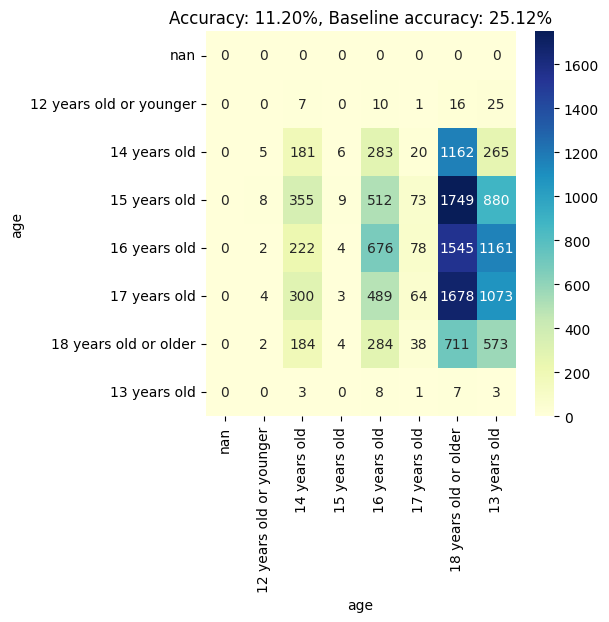

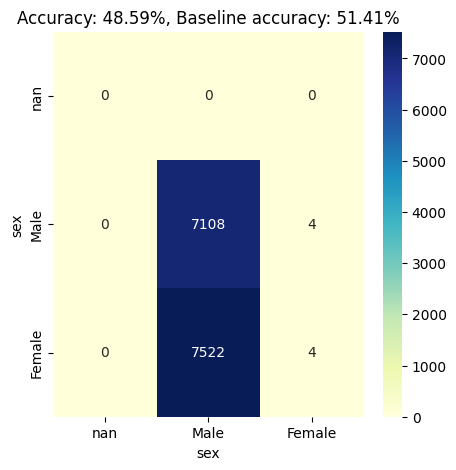

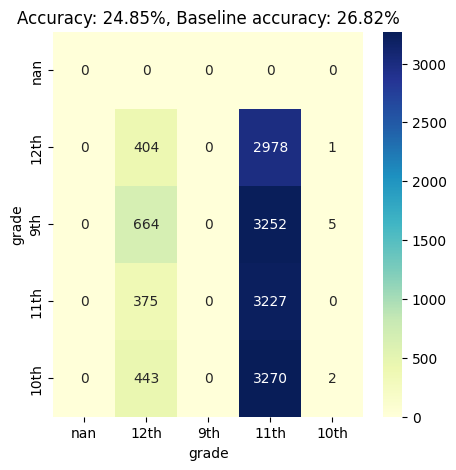

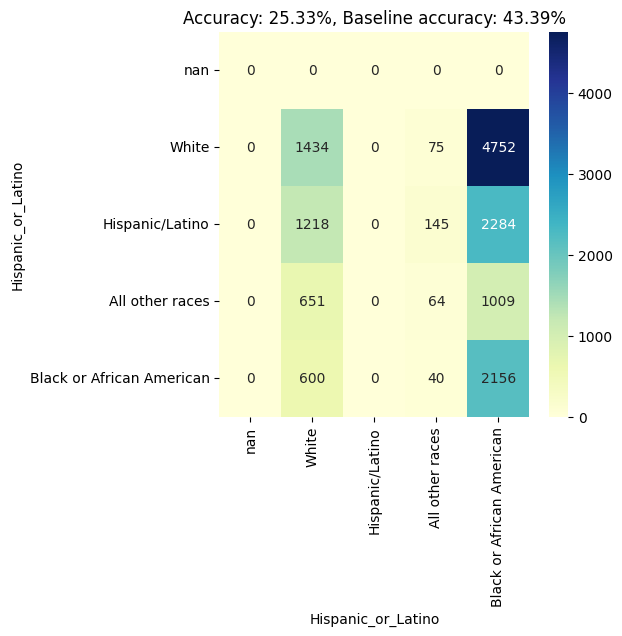

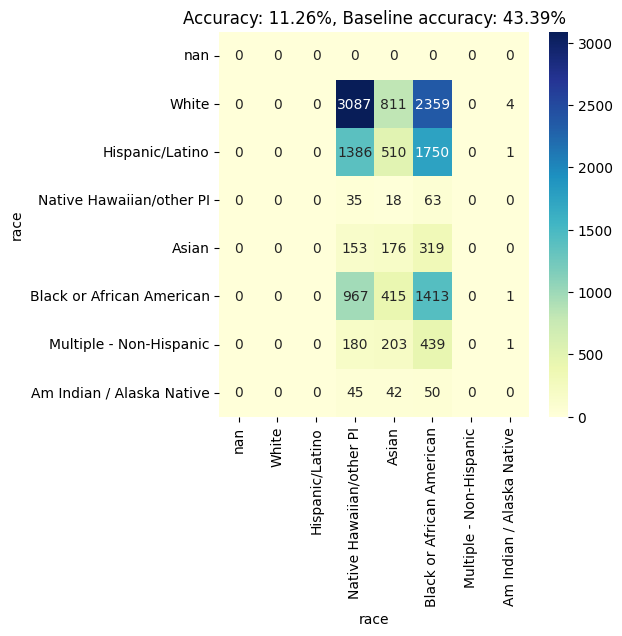

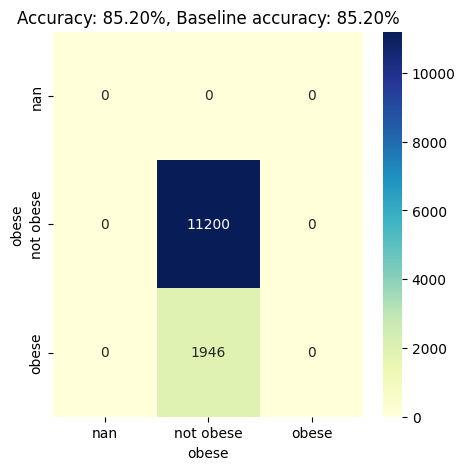

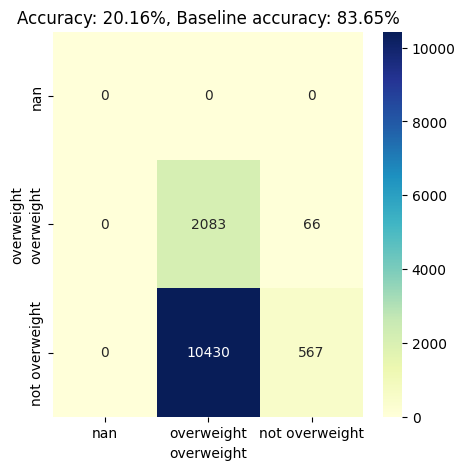

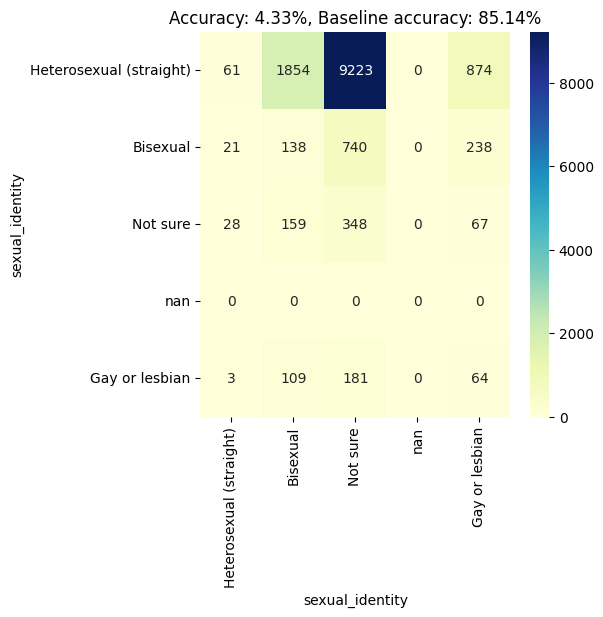

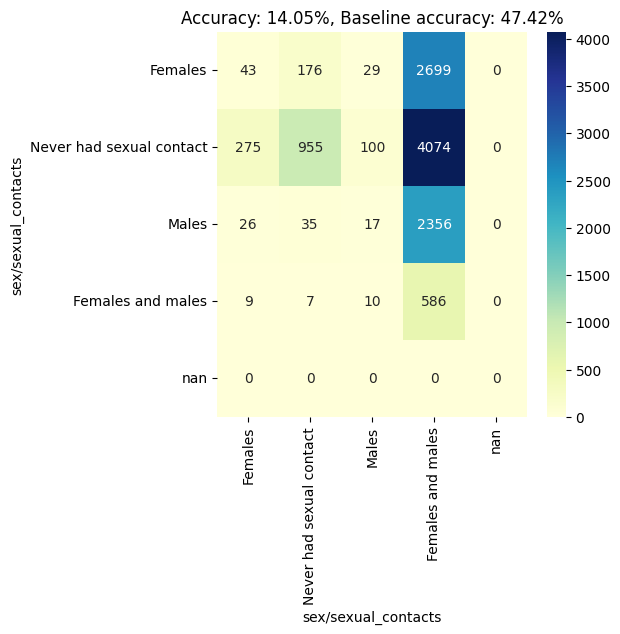

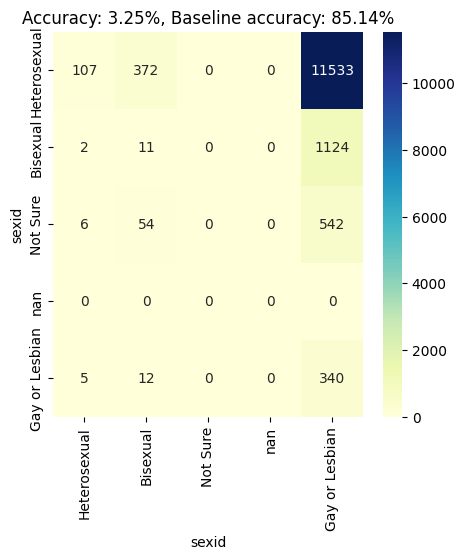

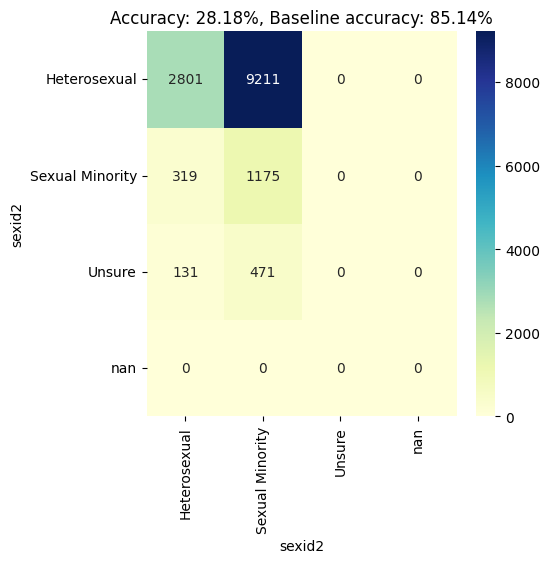

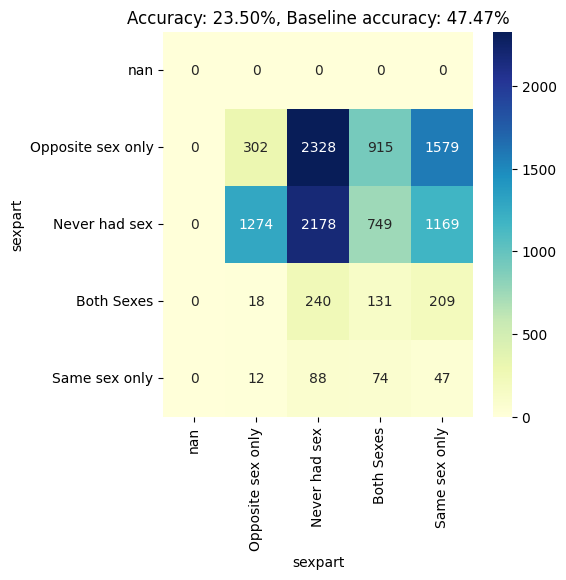

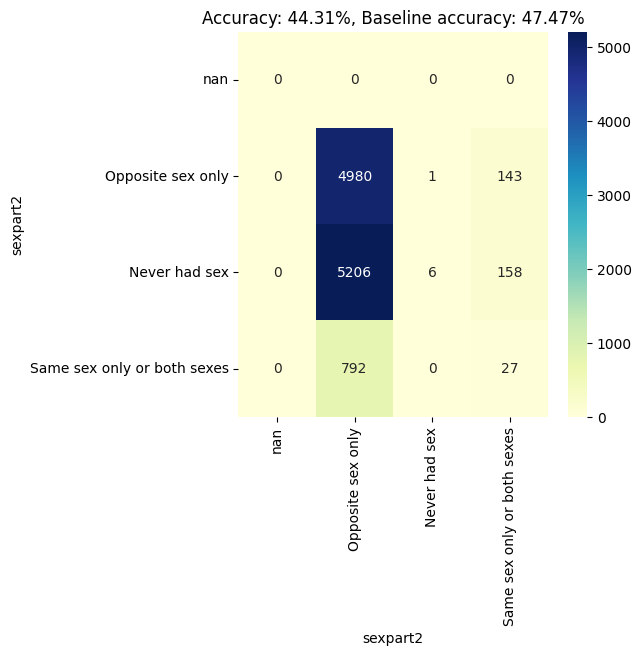

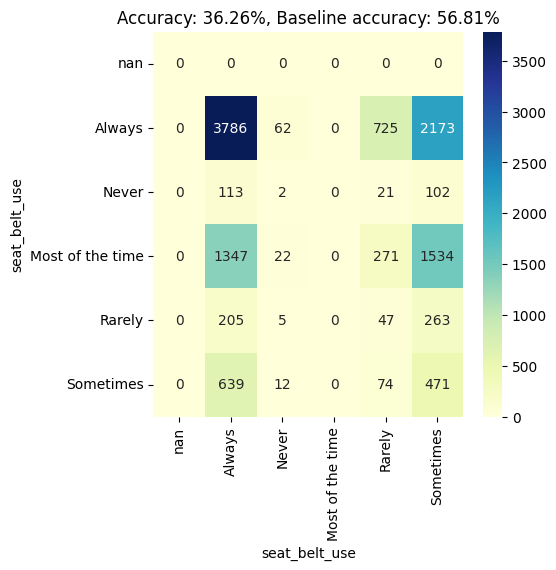

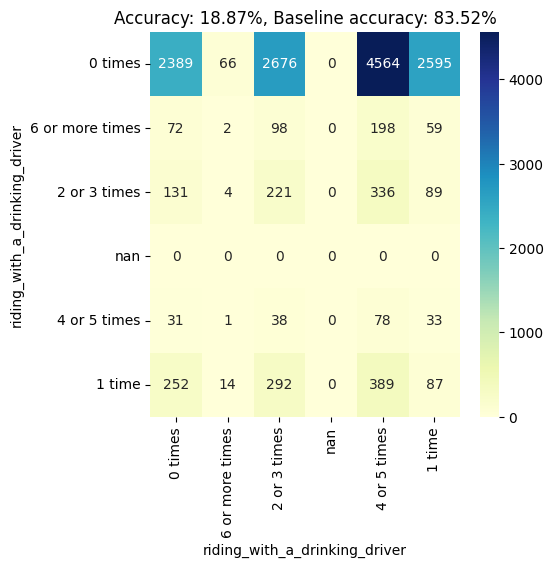

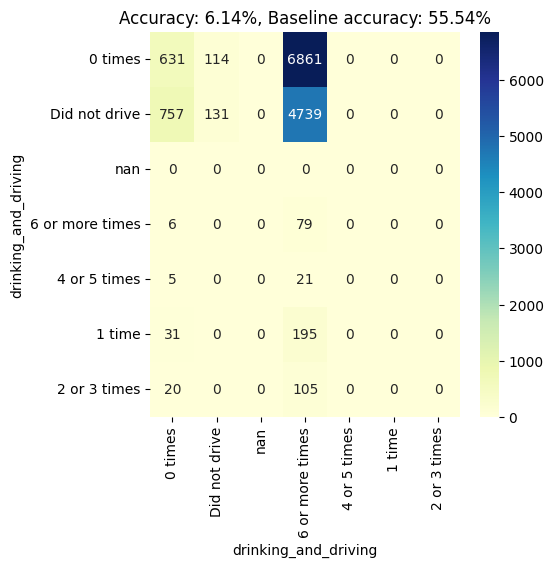

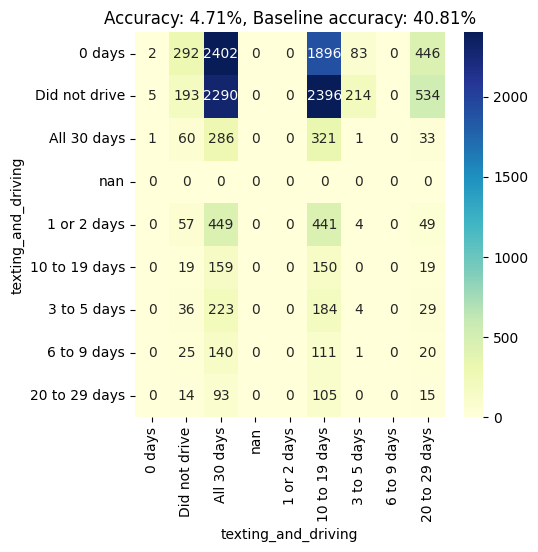

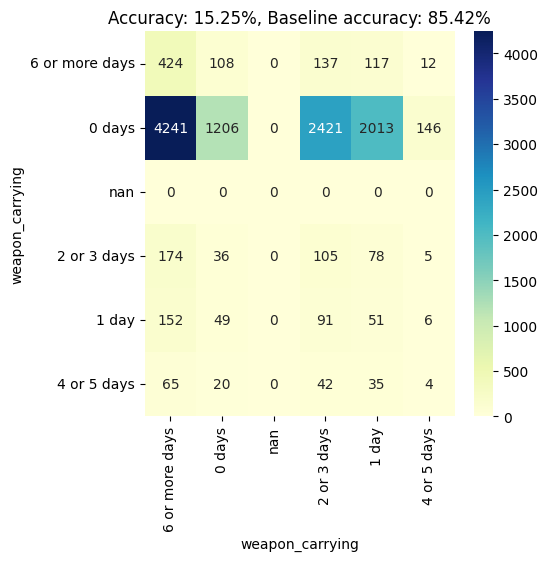

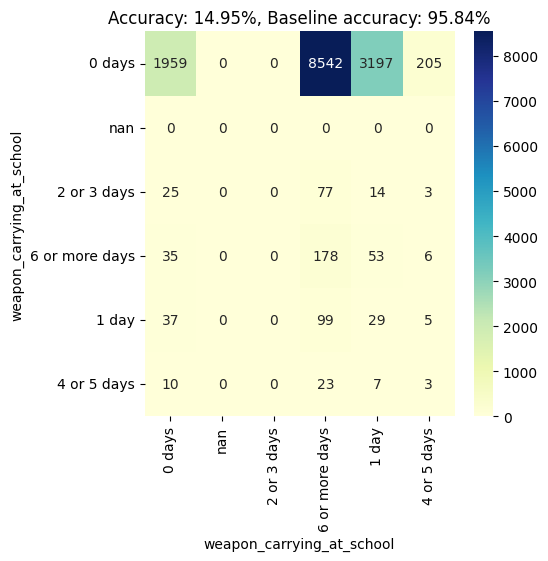

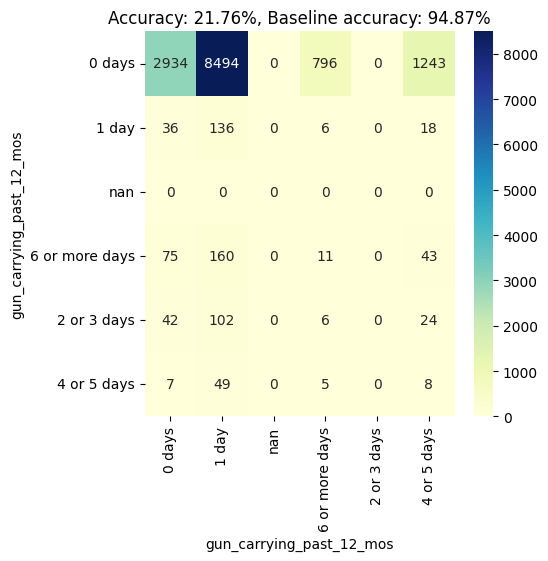

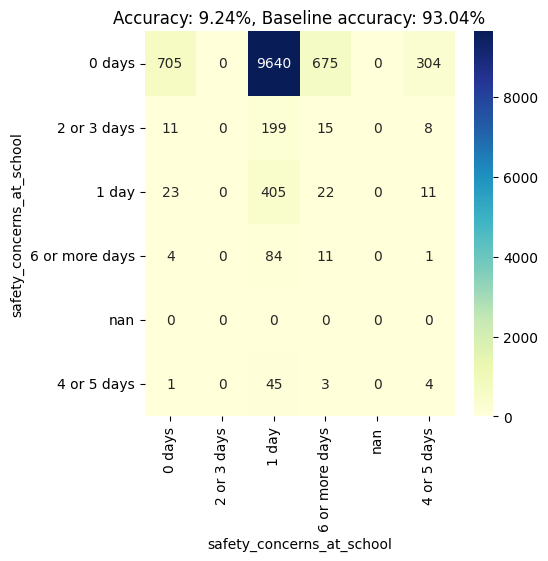

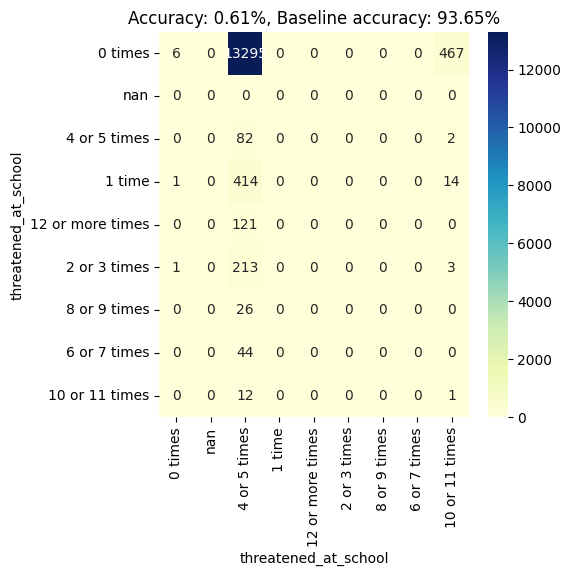

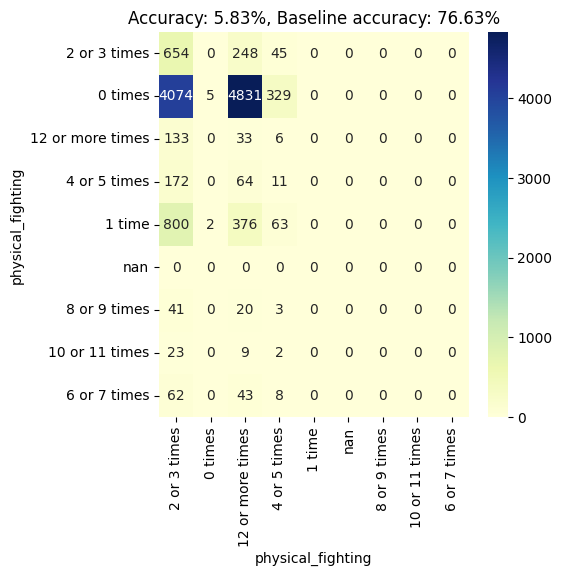

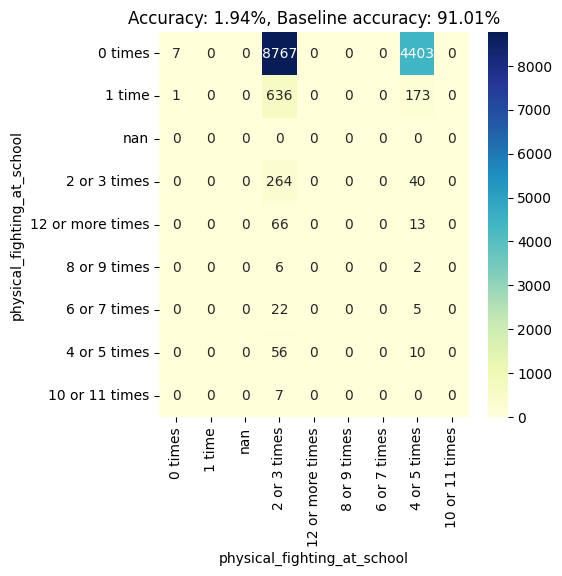

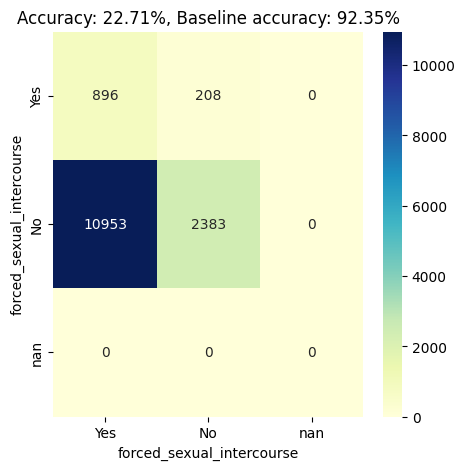

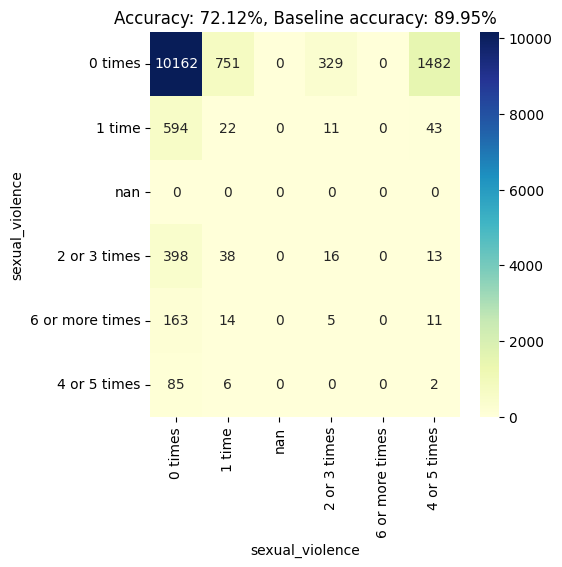

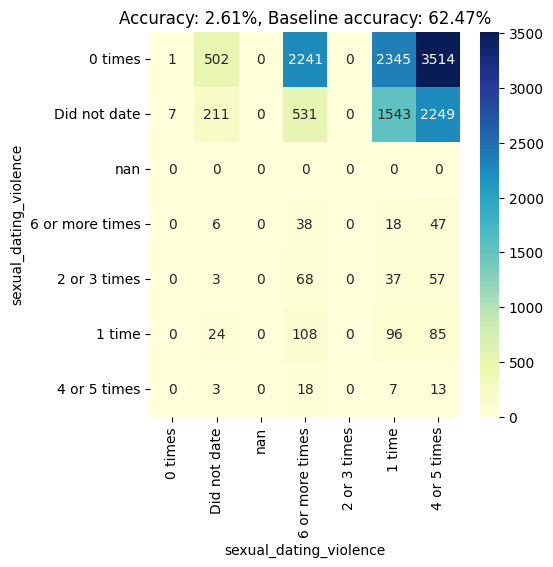

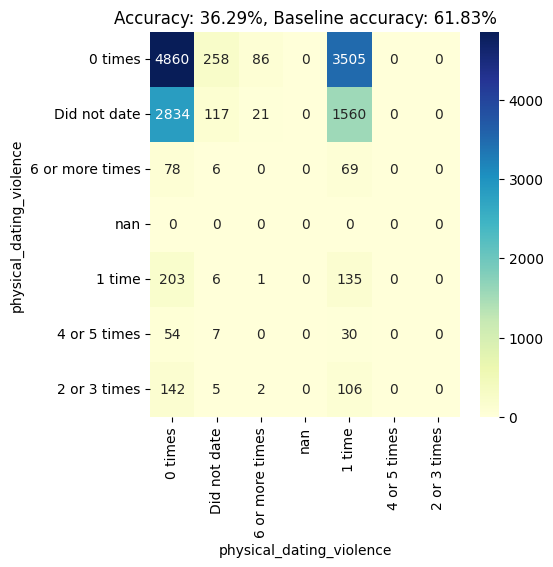

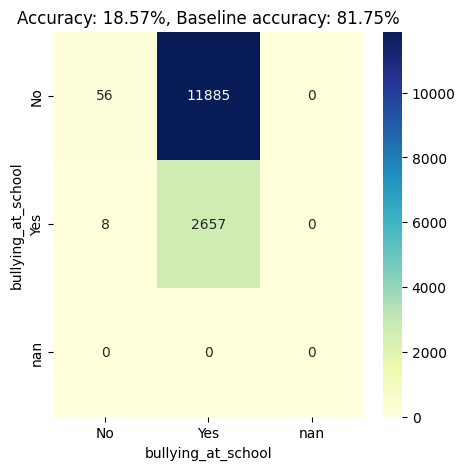

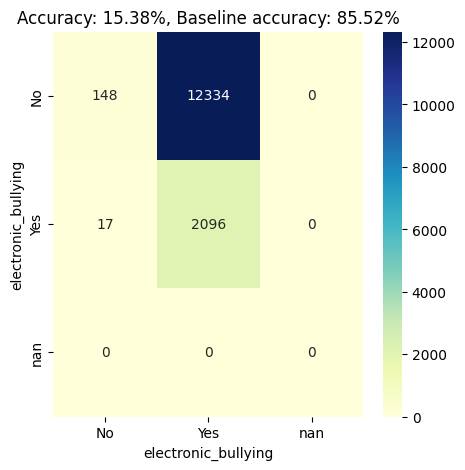

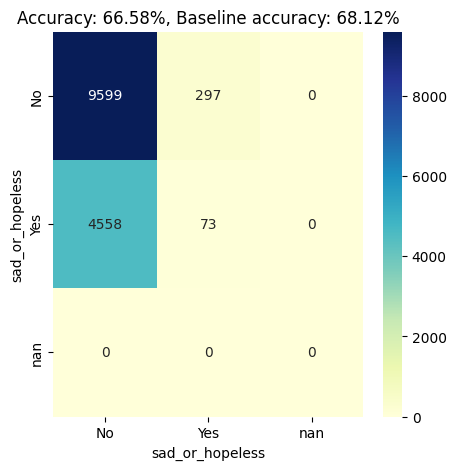

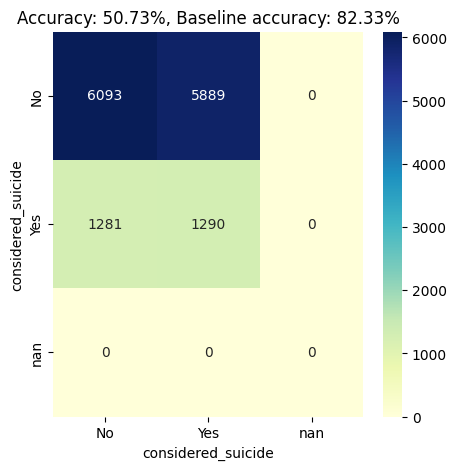

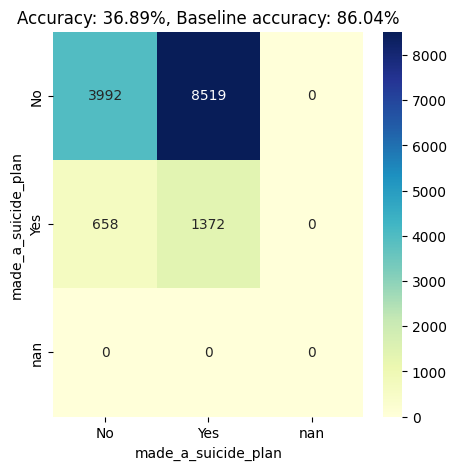

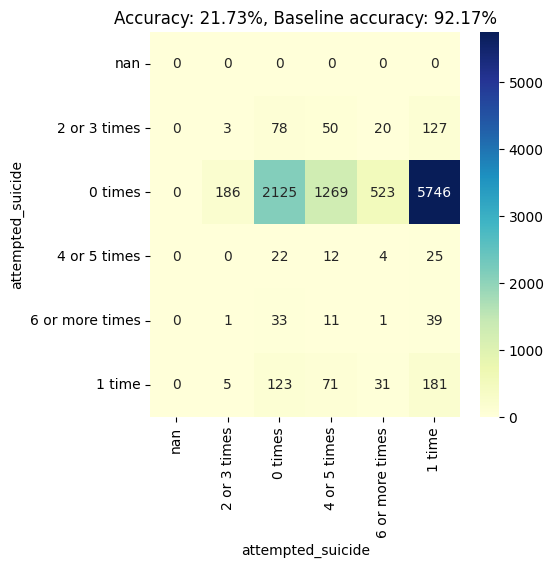

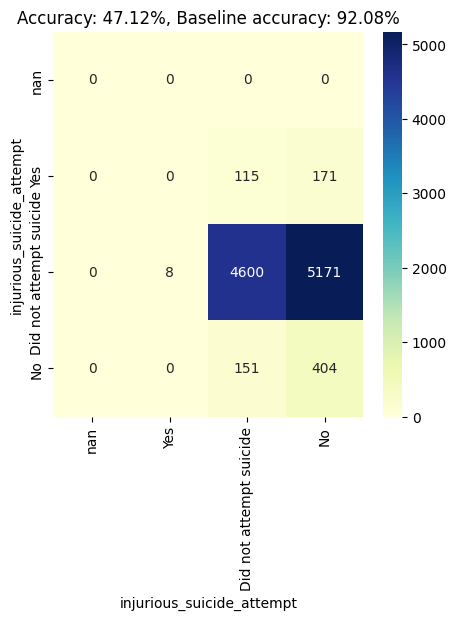

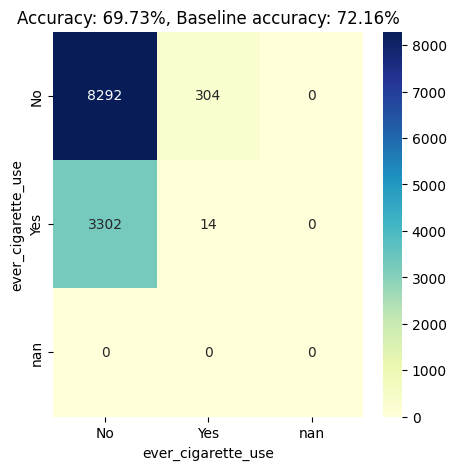

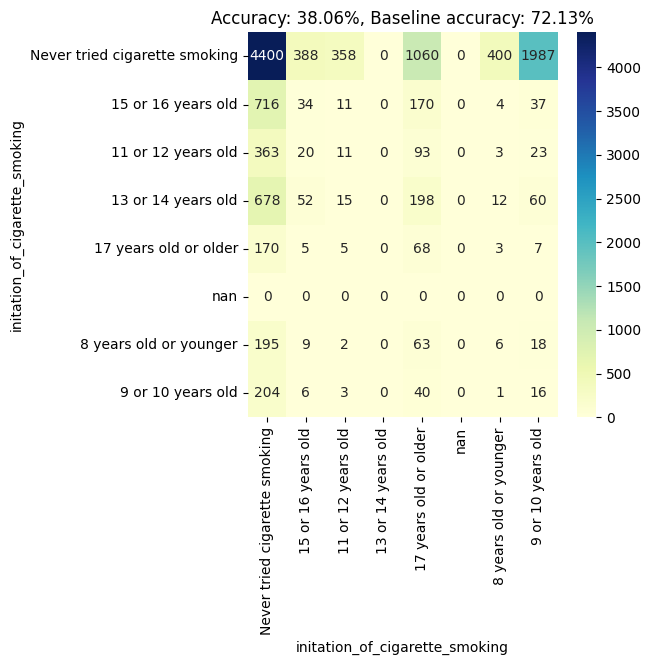

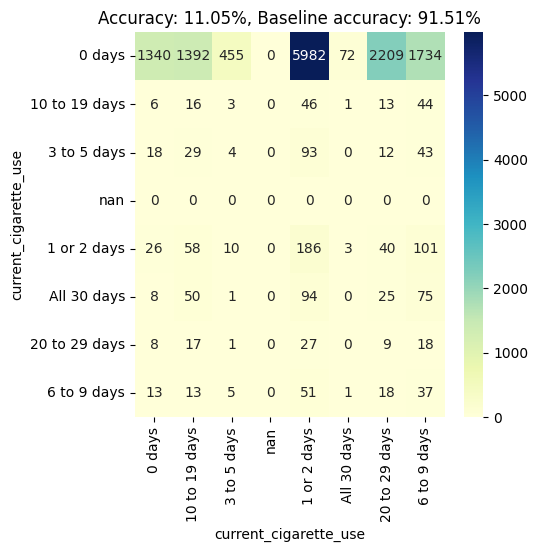

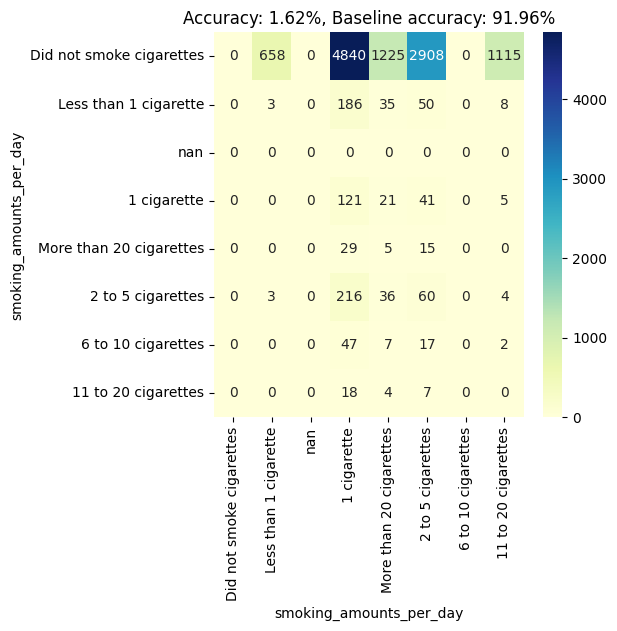

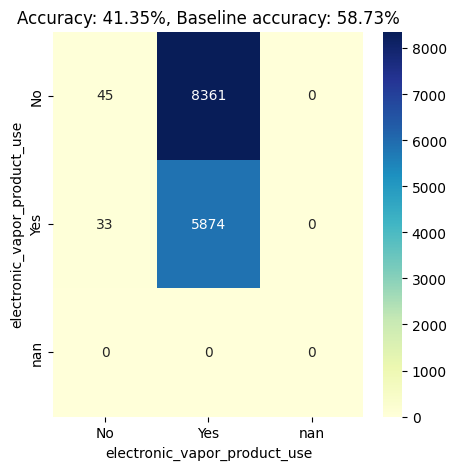

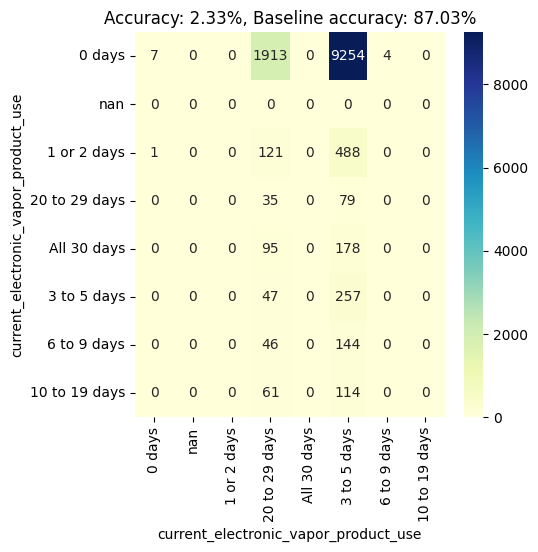

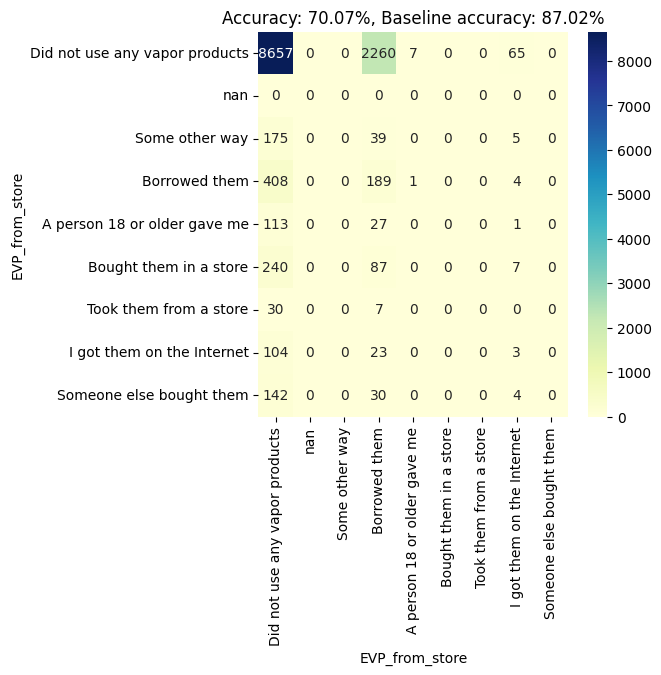

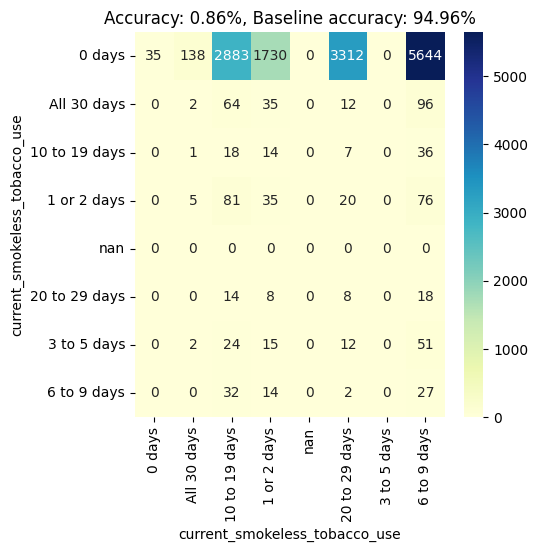

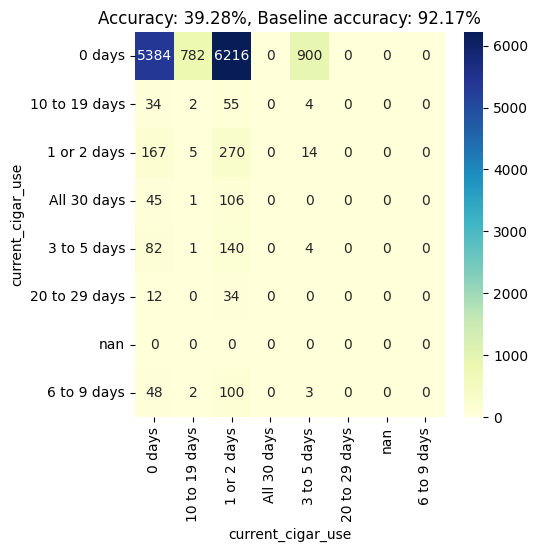

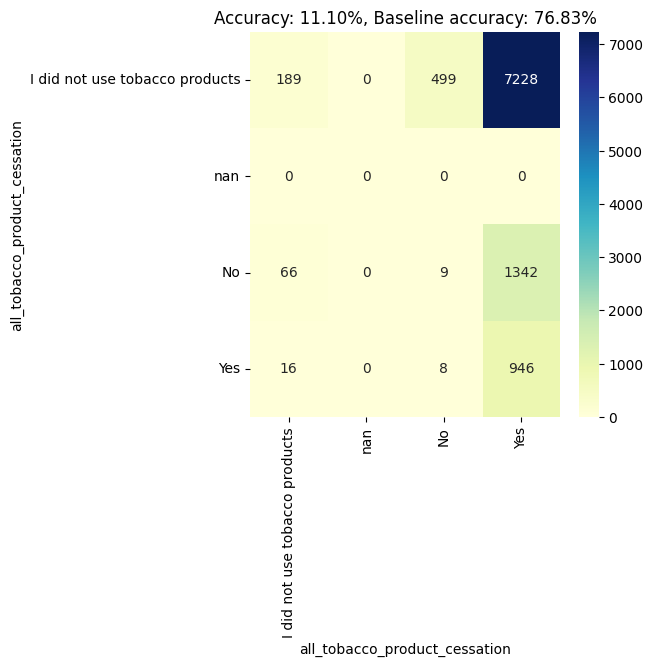

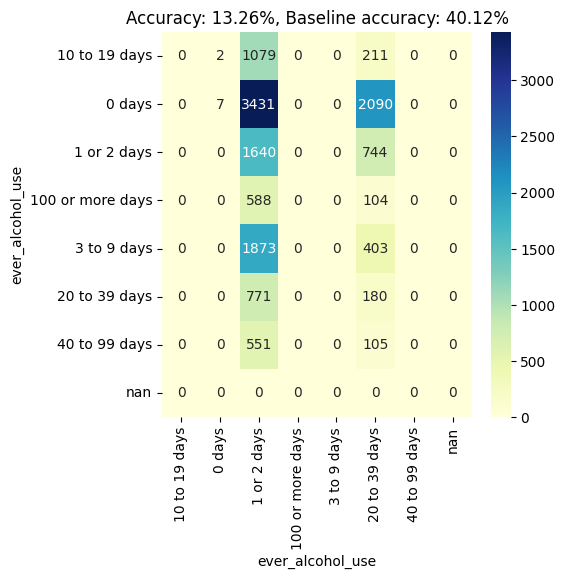

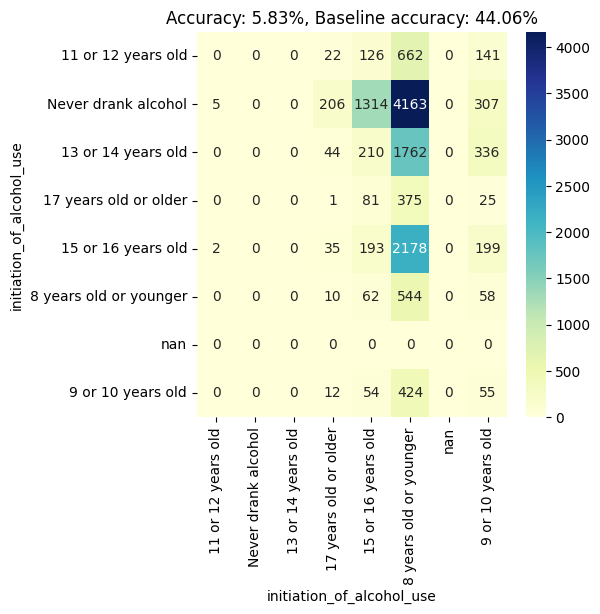

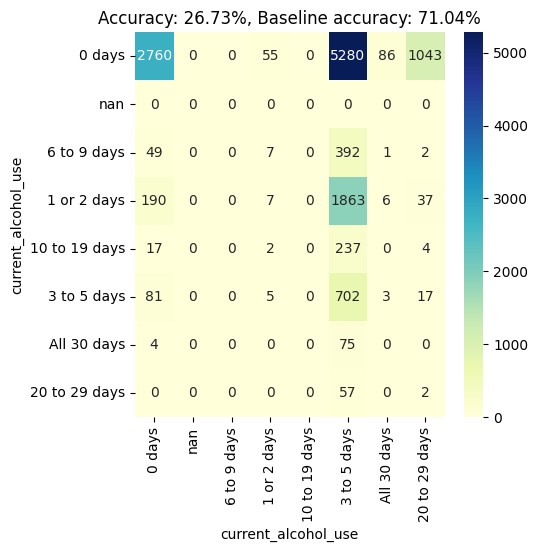

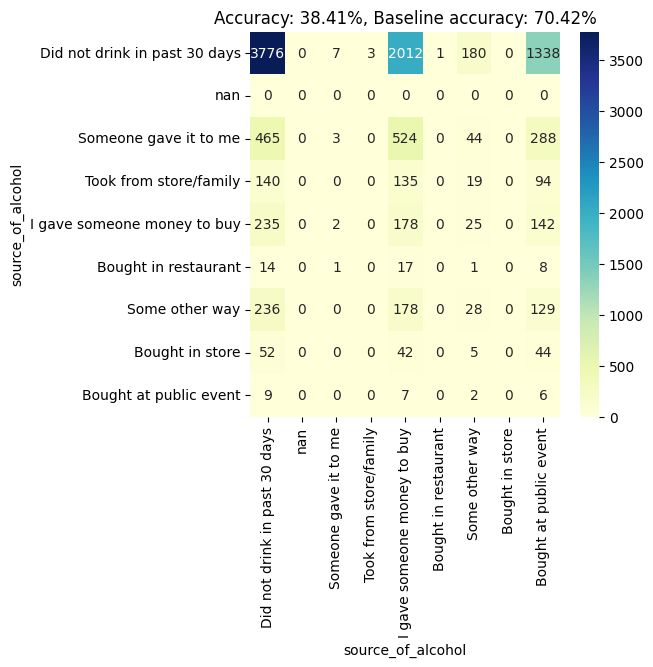

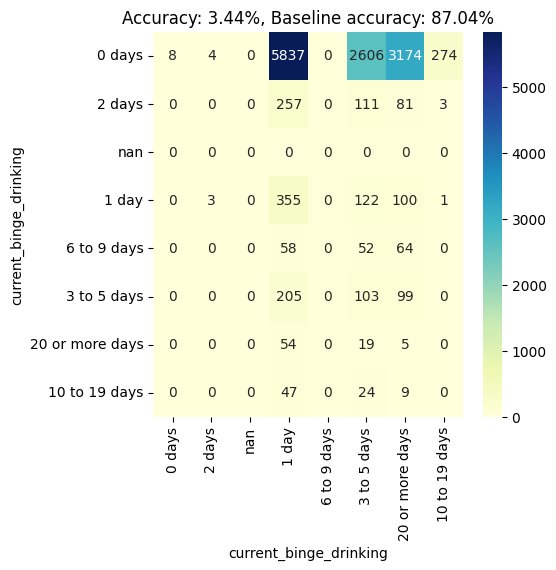

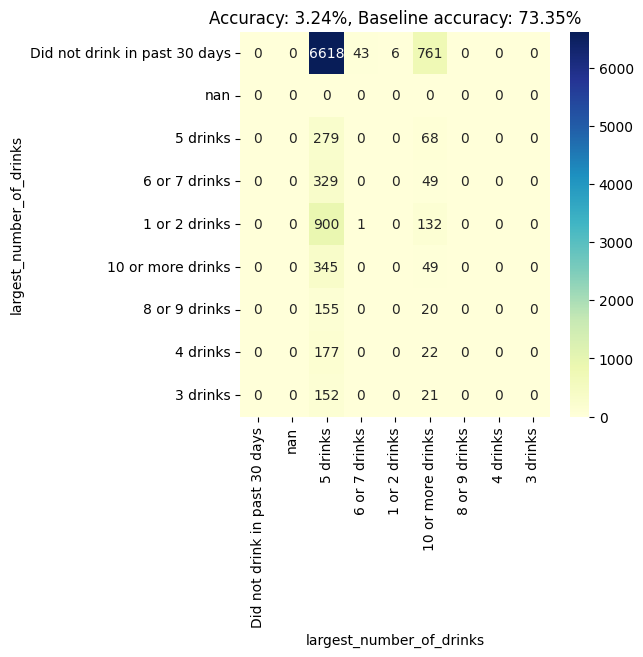

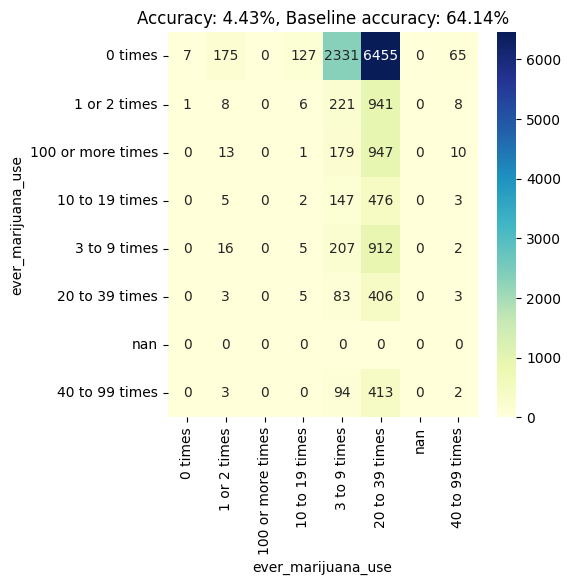

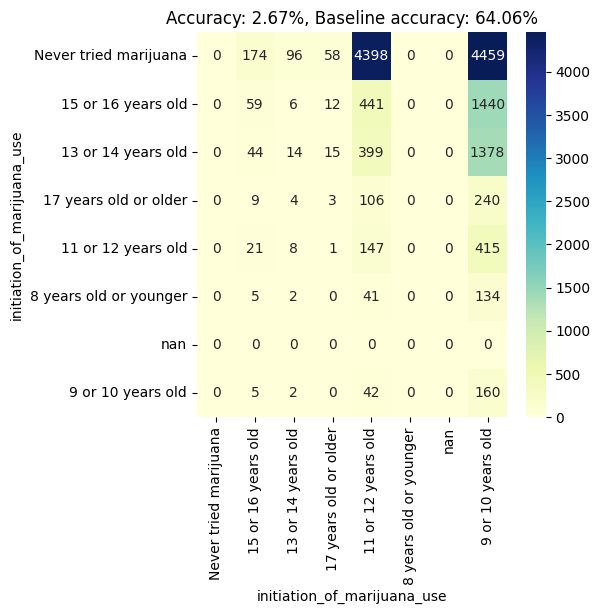

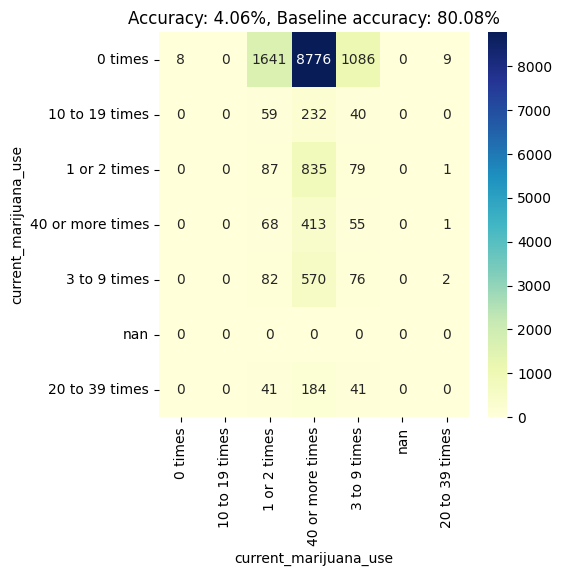

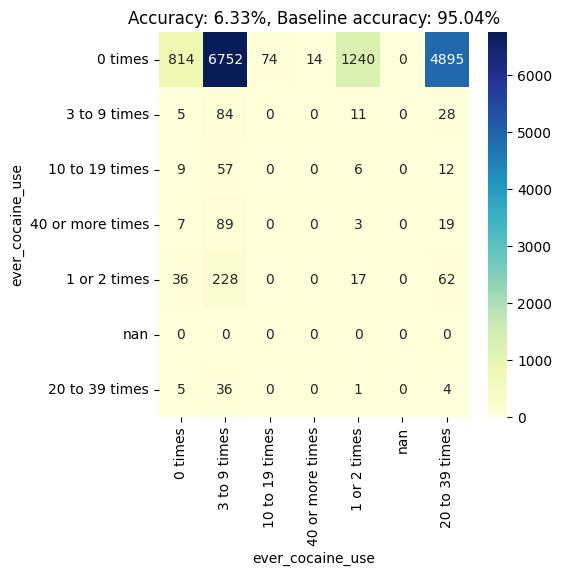

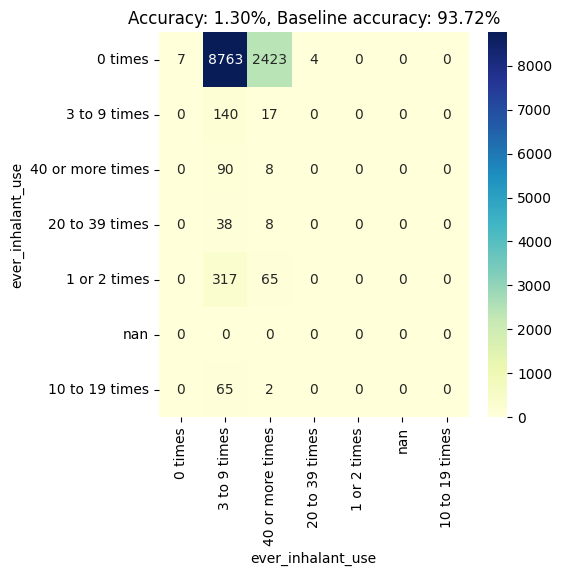

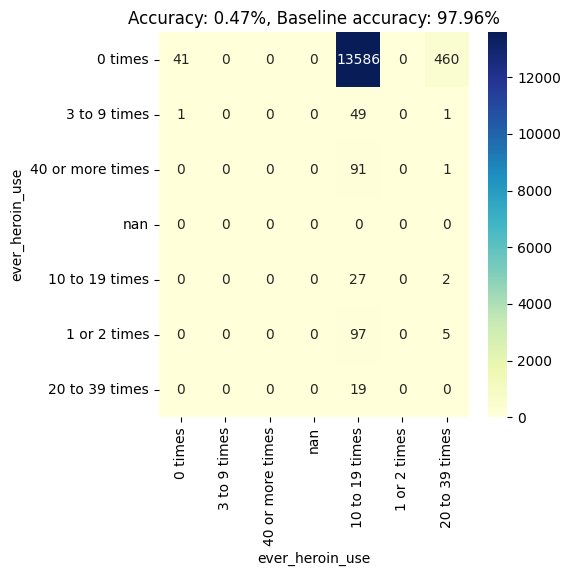

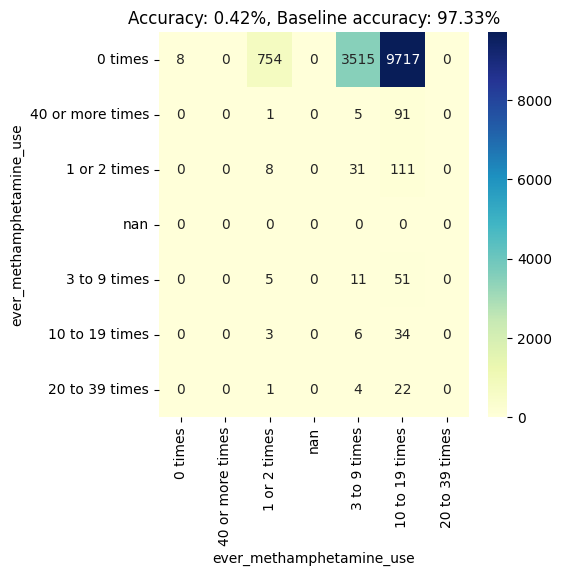

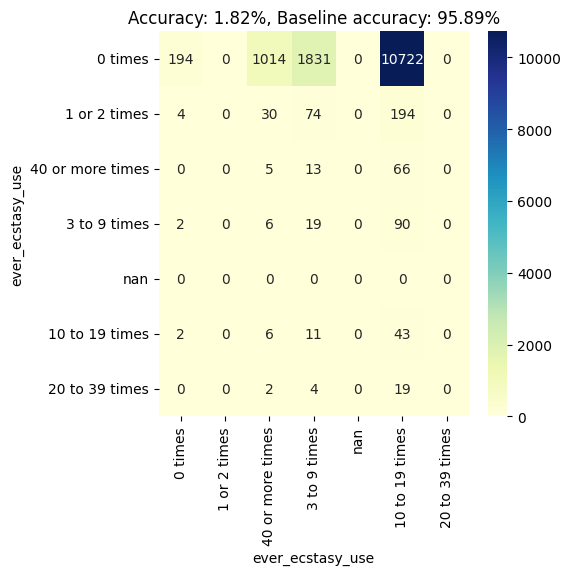

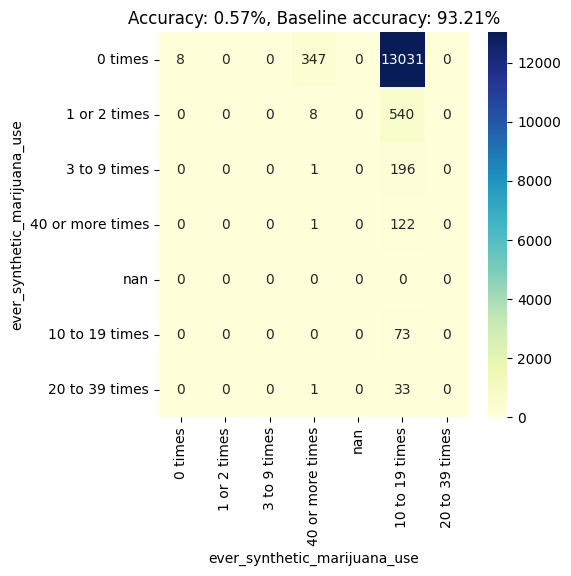

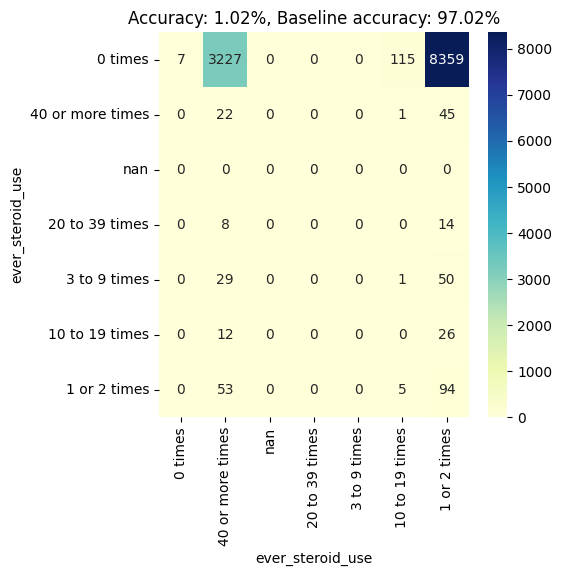

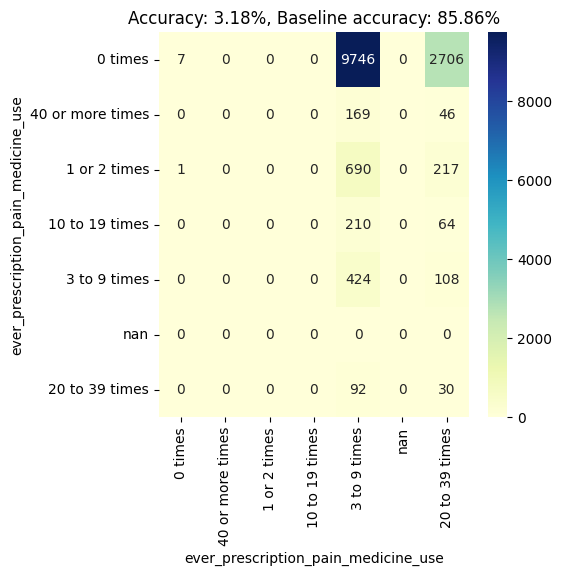

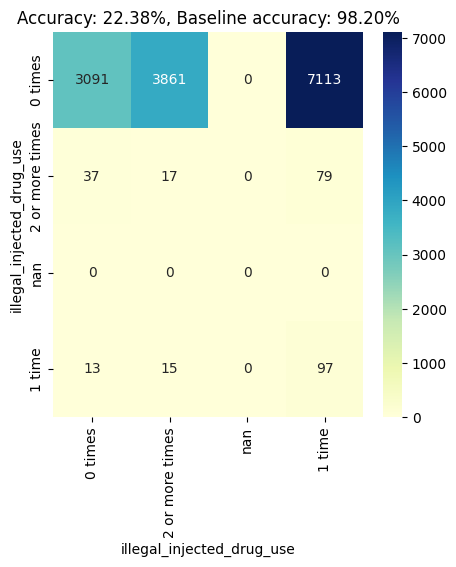

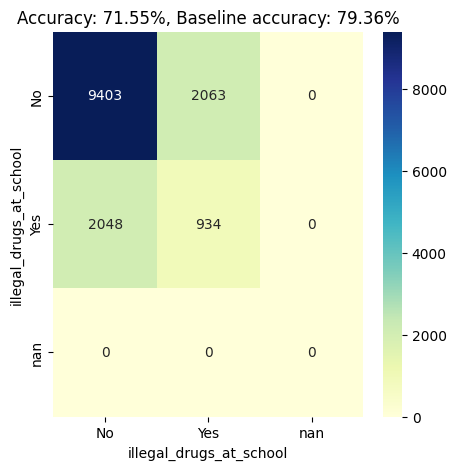

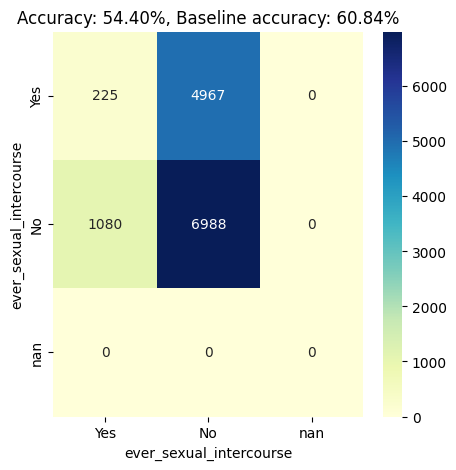

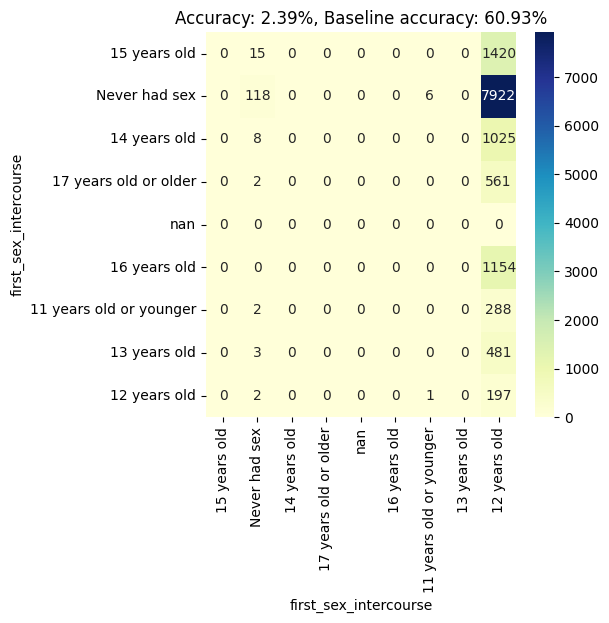

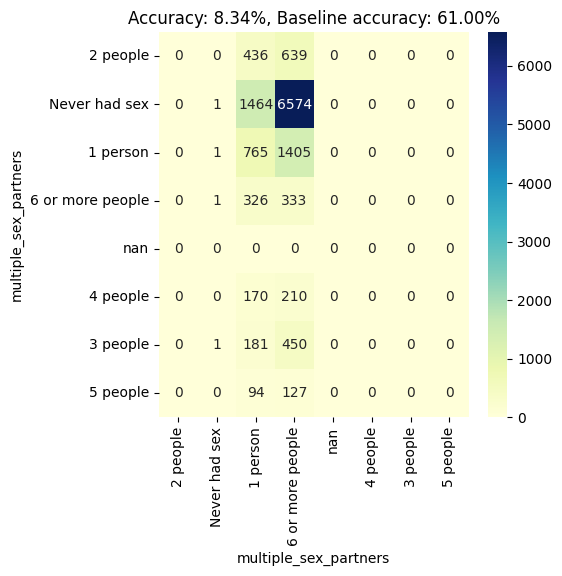

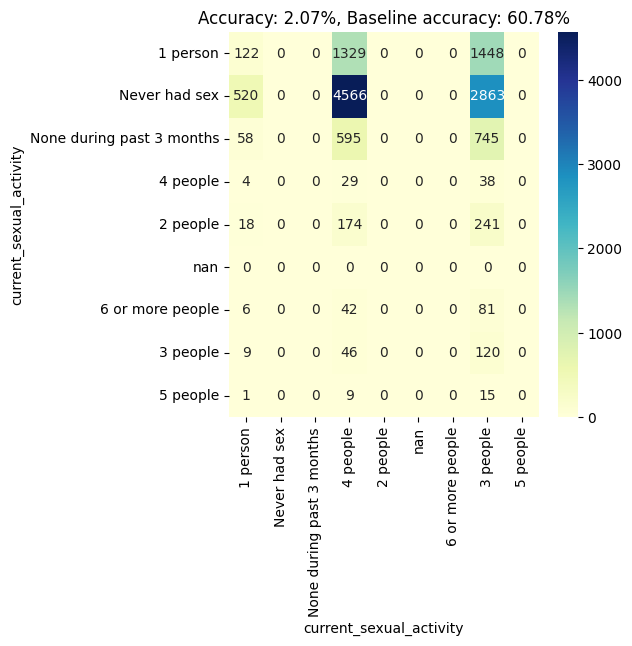

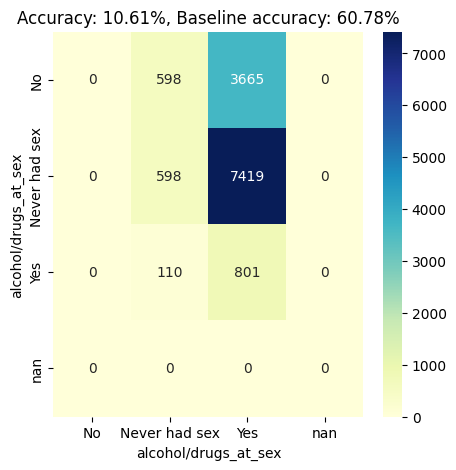

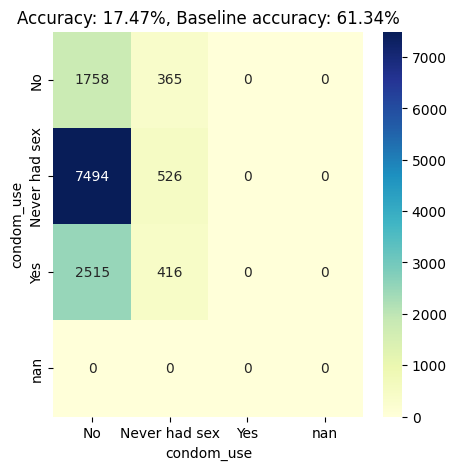

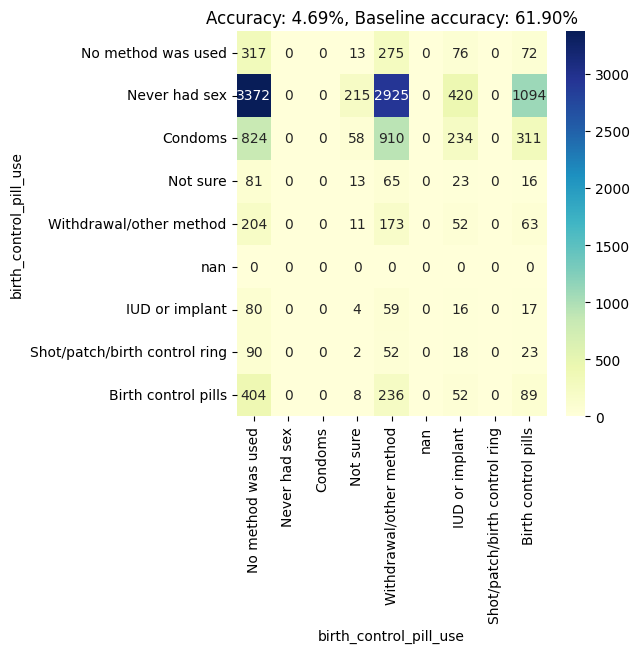

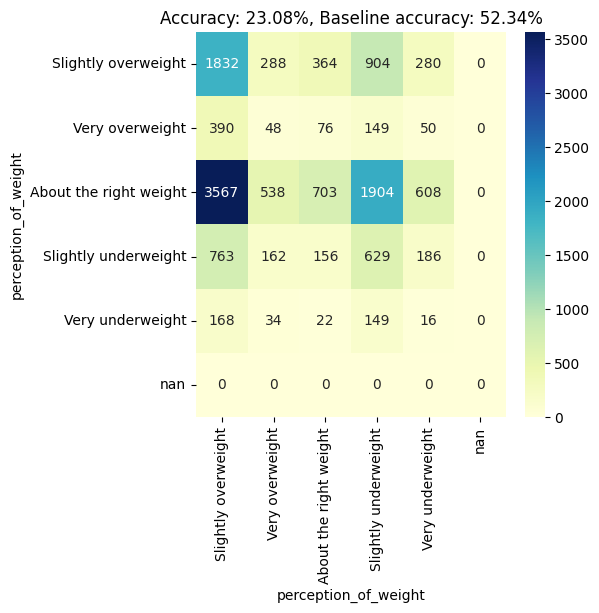

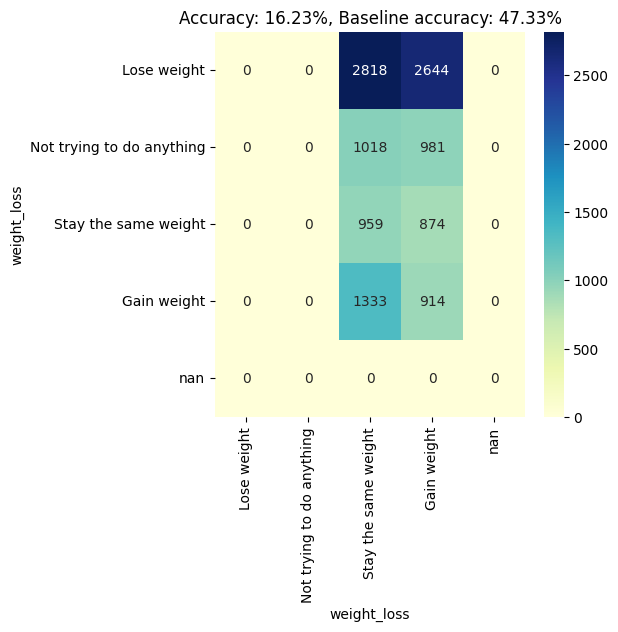

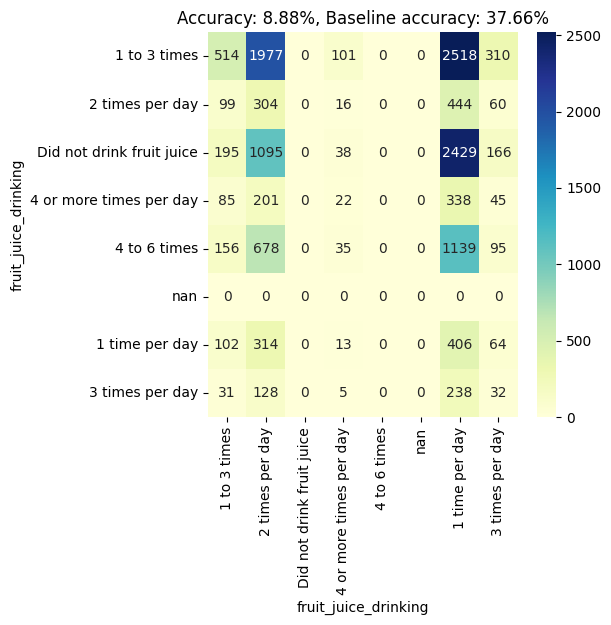

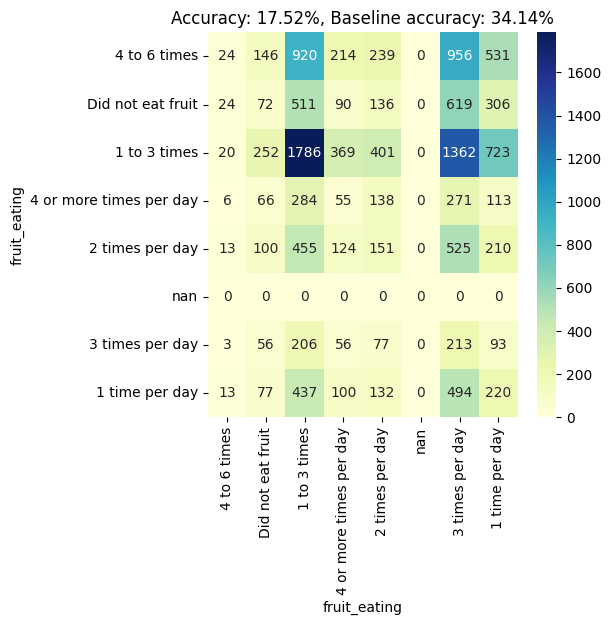

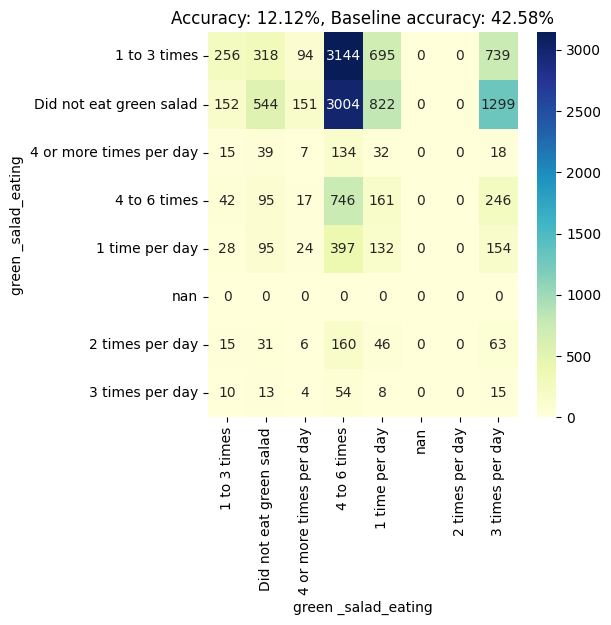

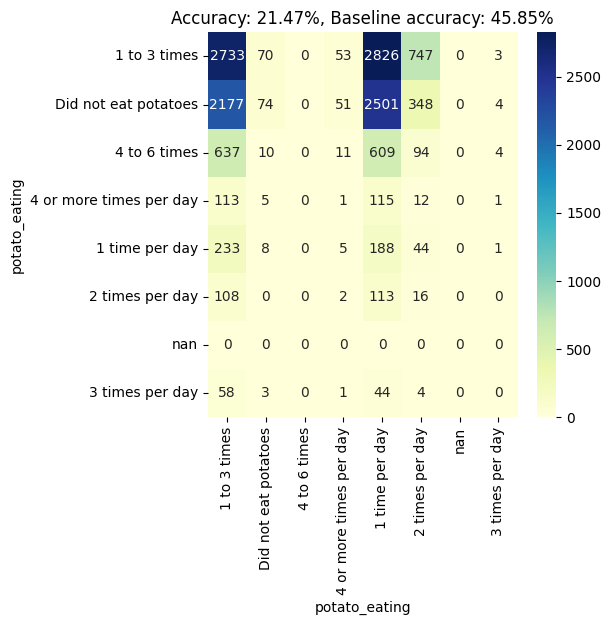

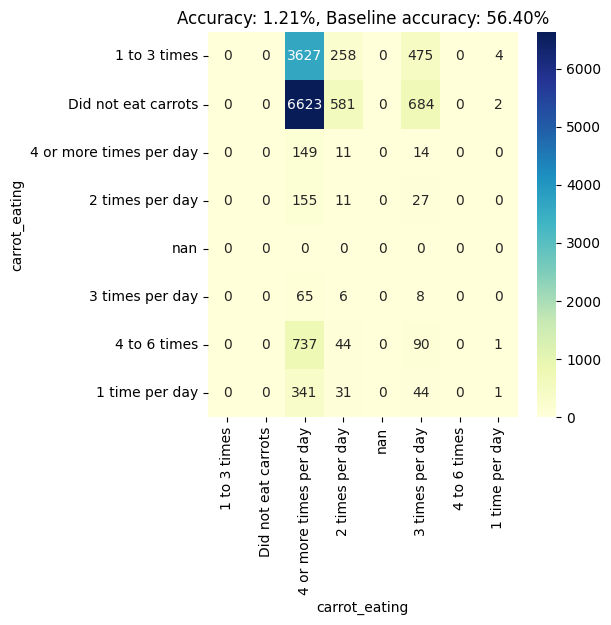

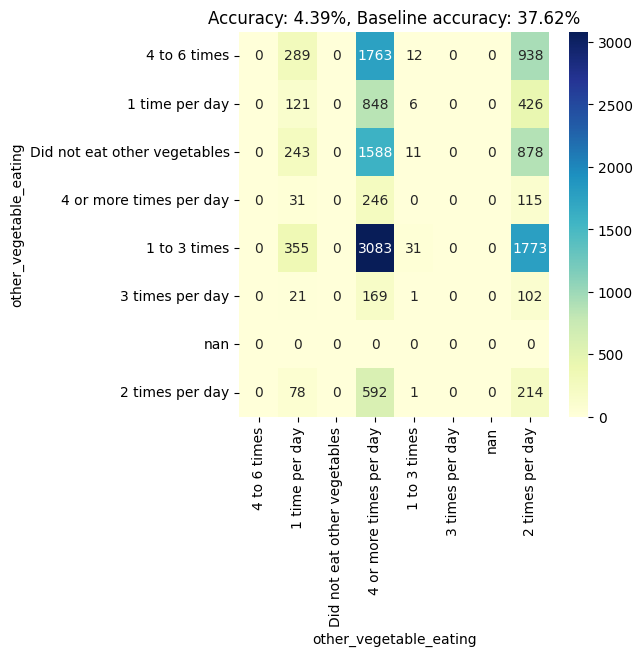

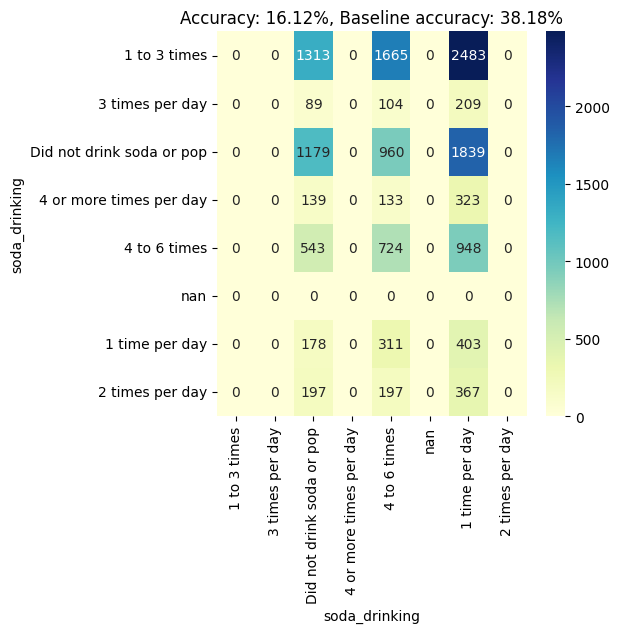

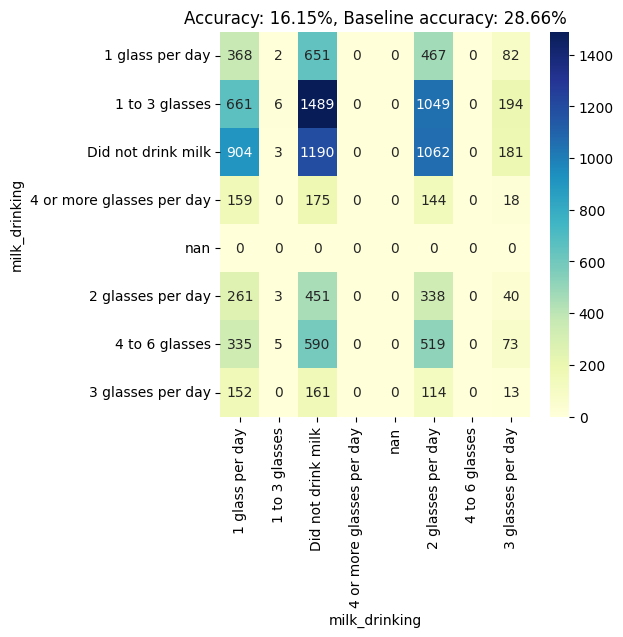

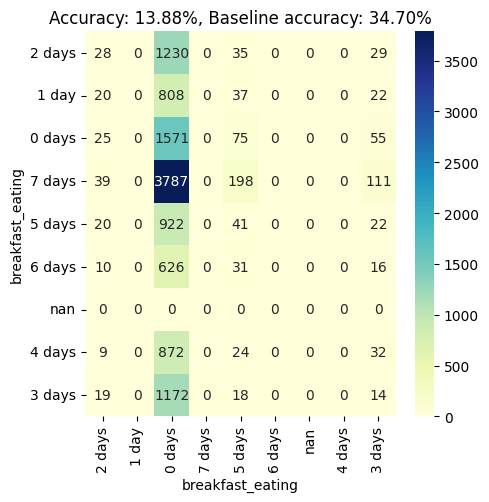

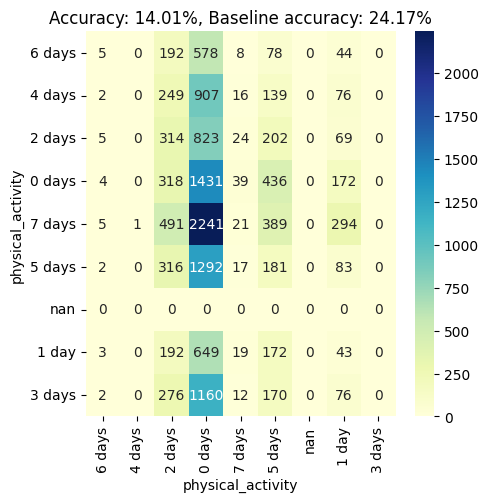

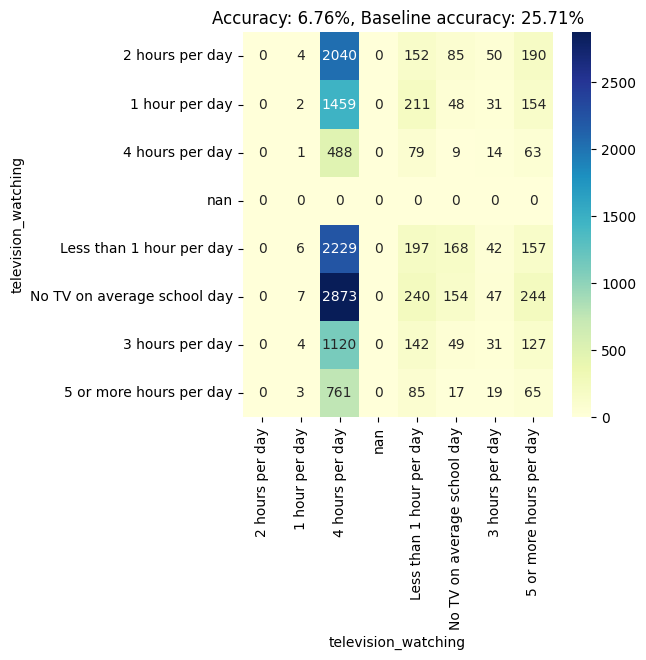

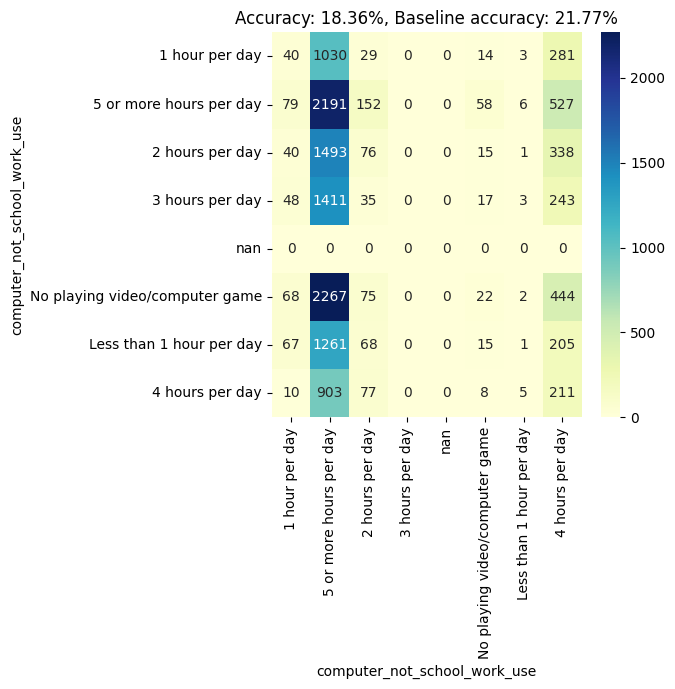

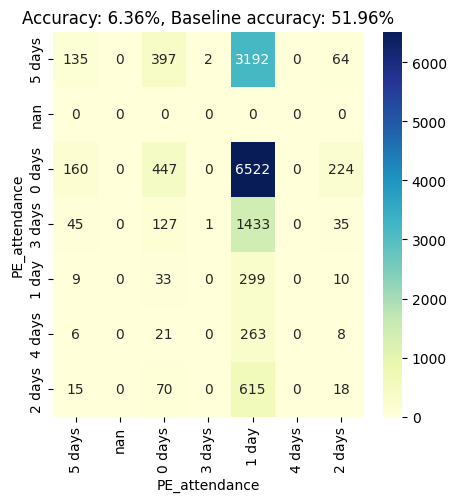

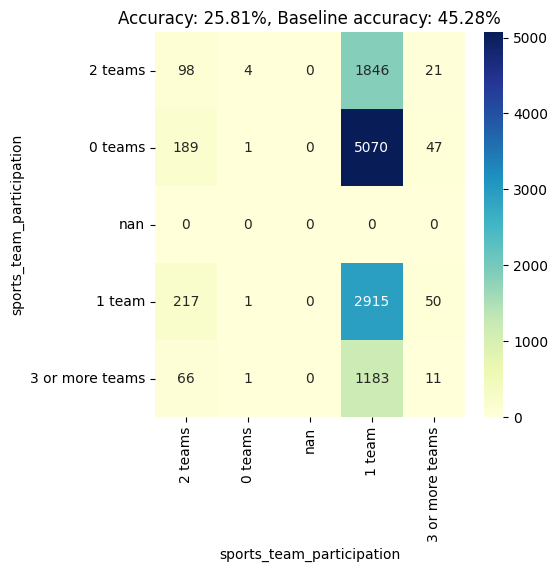

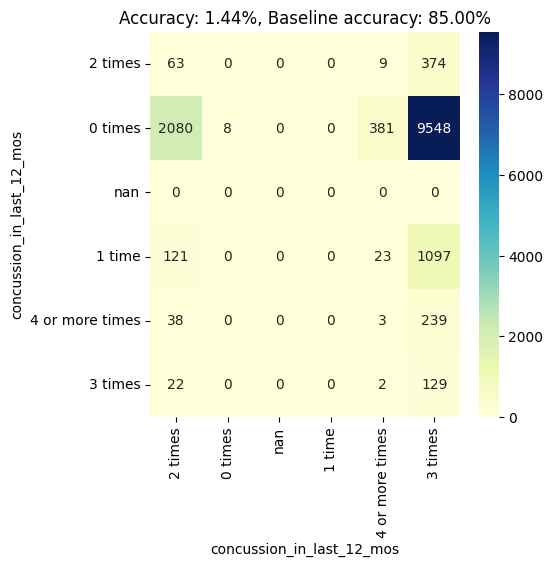

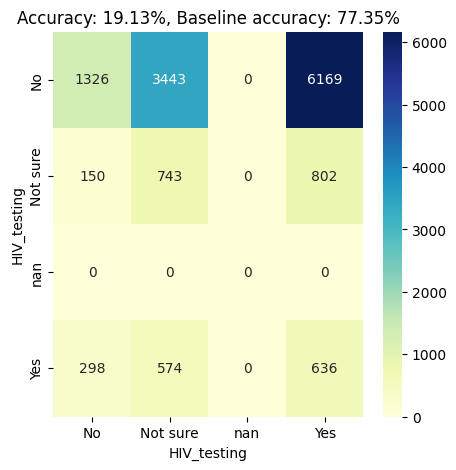

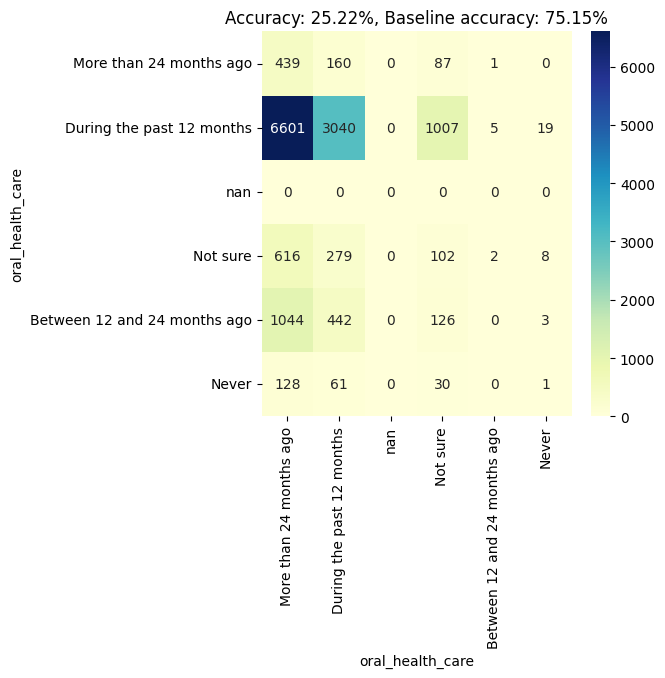

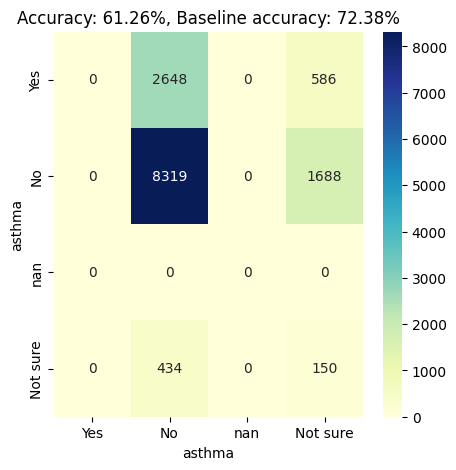

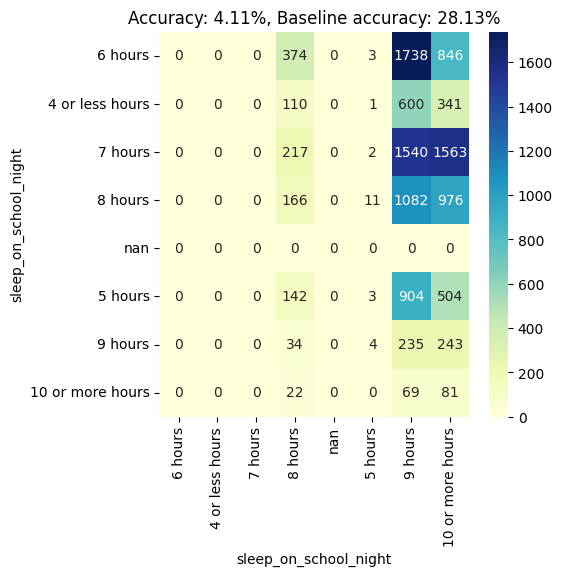

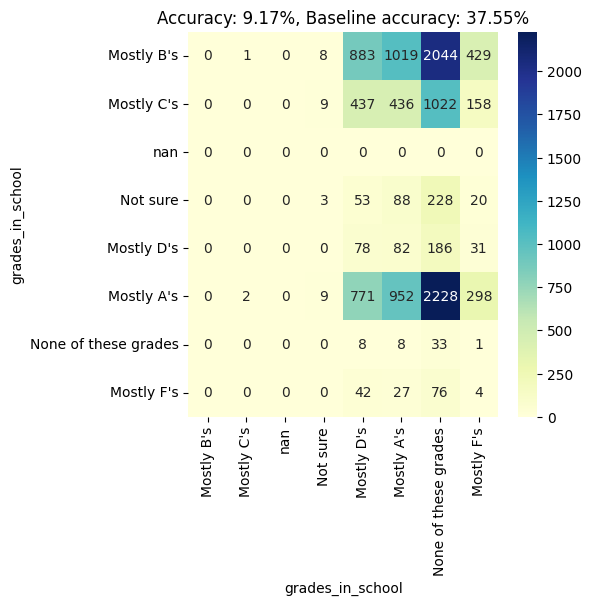

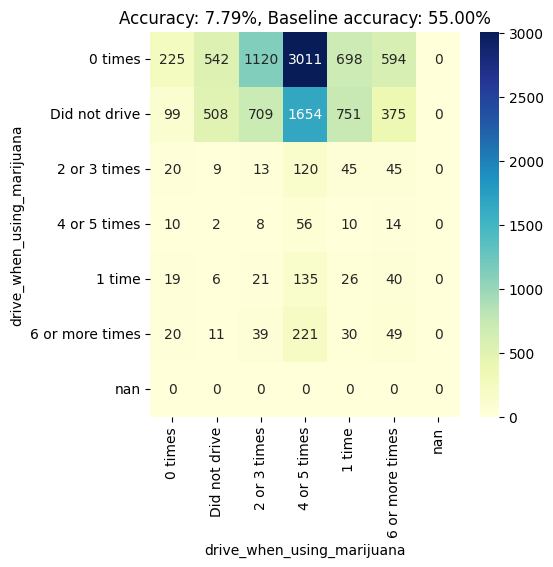

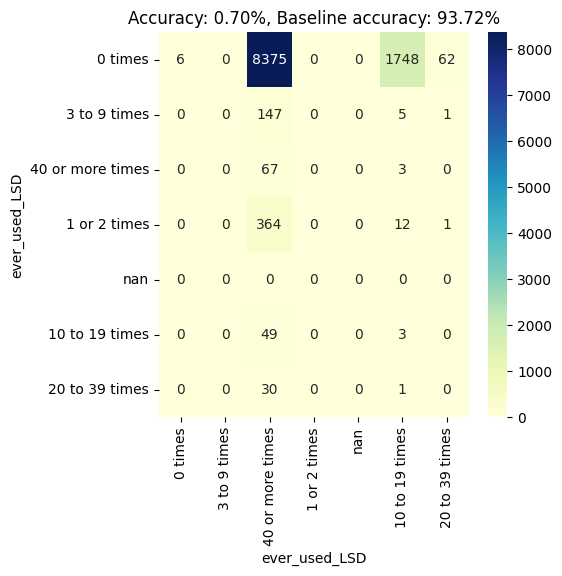

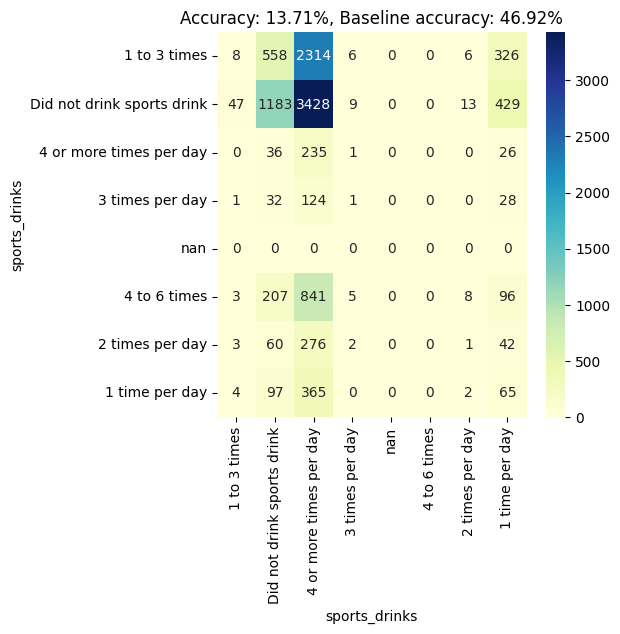

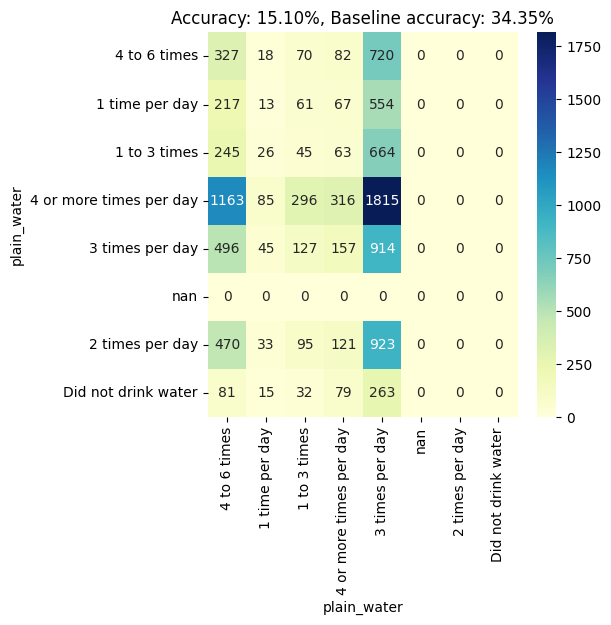

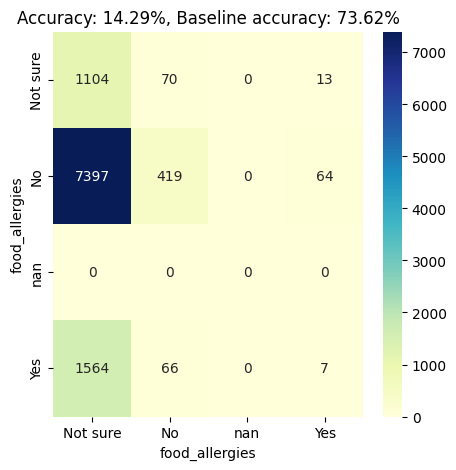

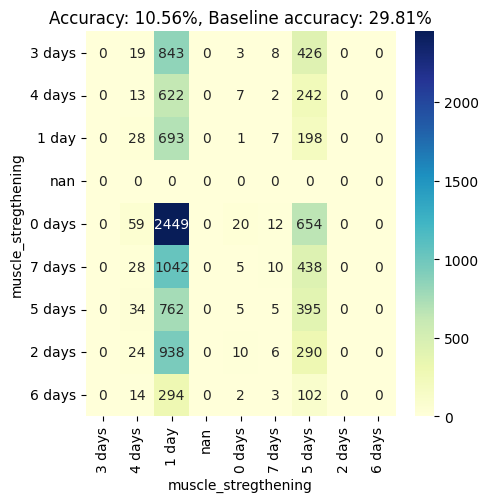

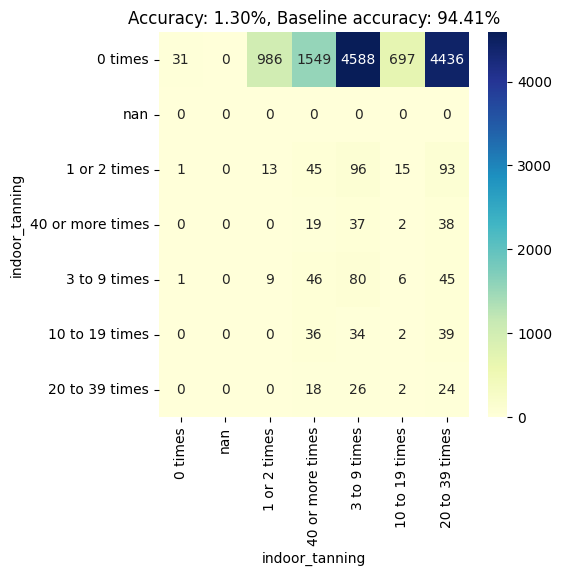

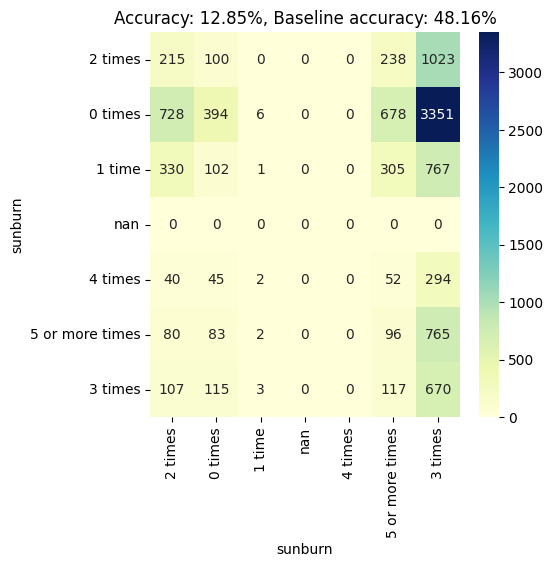

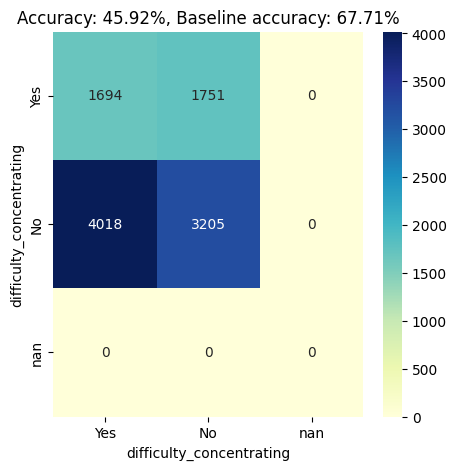

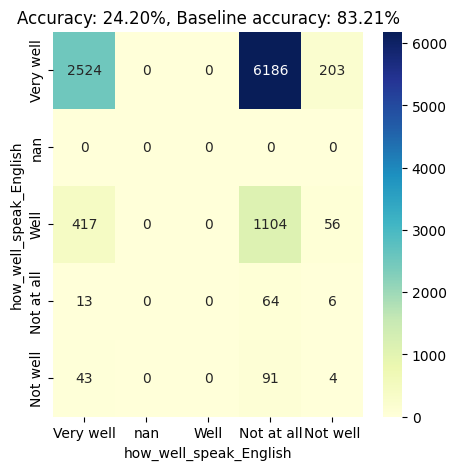

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_scatterplot_for_categorical(original_df, predicted_df, categ_attr):
    all_categories = original_df[categ_attr].unique()

    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])

    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)
    accuracy = diagonal_sum / total_sum * 100

    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100

    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Accuracy: {accuracy:.2f}%, Baseline accuracy: {baseline_accuracy:.2f}%")
    plt.show()


for v in var_types.keys():
  if var_types[v] == 'categorical':
    # print(v)
    create_scatterplot_for_categorical(project_data, reversed_data, v)

# What if I don't use maximum-likelihood in reversing the dataframe

In [22]:
reversed_data.to_csv('binary_crossentropy_reverse.csv', index=False)
from google.colab import files
files.download('binary_crossentropy_reverse.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SparseCategoricalCrossEntropy ------------------------------------------------


In [23]:
encoded_sparse_data = project_data.copy()

from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for column in project_data.columns:
    label_encoder = LabelEncoder()
    encoded_sparse_data[column] = label_encoder.fit_transform(encoded_sparse_data[column])
    label_encoders[column] = label_encoder

encoded_sparse_data

age  sex  grade  Hispanic_or_Latino  race  obese  overweight  \
0        7    2      4                   4     7      2           2   
1        7    2      4                   4     7      2           2   
2        7    2      4                   4     7      2           2   
3        7    2      4                   4     7      2           2   
4        7    2      4                   4     7      2           2   
...    ...  ...    ...                 ...   ...    ...         ...   
14760    6    0      4                   2     3      2           2   
14761    6    0      4                   4     7      2           2   
14762    6    0      4                   2     3      2           2   
14763    6    0      2                   3     6      0           0   
14764    6    0      2                   4     7      2           2   

       sexual_identity  sex/sexual_contacts  sexid  ...  muscle_stregthening  \
0                    2                    0      2  ...                    3   
1                    0                    3      0  ...                    4   
2                    2                    2      2  ...                    1   
3                    2                    0      2  ...                    3   
4                    2                    3      2  ...                    8   
...                ...                  ...    ...  ...                  ...   
14760                2                    4      2  ...                    8   
14761                3                    4      3  ...                    8   
14762                3                    4      3  ...                    8   
14763                2                    4      2  ...                    8   
14764                1                    4      1  ...                    8   

       indoor_tanning  sunburn  difficulty_concentrating  \
0                   0        2                         1   
1                   0        0                         1   
2                   0        0                         0   
3                   0        1                         0   
4                   6        6                         2   
...               ...      ...                       ...   
14760               6        6                         2   
14761               5        6                         2   
14762               6        6                         2   
14763               0        6                         2   
14764               1        6                         2   

       how_well_speak_English  weight_cat  stheight_cat  stweight_cat  \
0                           2           0             1             0   
1                           2           0             1             0   
2                           2           0             1             0   
3                           2           0             1             0   
4                           4           0             1             0   
...                       ...         ...           ...           ...   
14760                       4           0             1             0   
14761                       4           0             1             0   
14762                       4           0             1             0   
14763                       4           0             2             1   
14764                       4           0             1             0   

       bmi_cat  bmipct_cat  
0            1           0  
1            1           0  
2            1           0  
3            1           0  
4            1           0  
...        ...         ...  
14760        1           0  
14761        1           0  
14762        1           0  
14763        2           1  
14764        1           0  

[14765 rows x 108 columns]

In [24]:
import tensorflow as tf

input_dim = 108
num_classes = 10
training_data, val_data = train_test_split(encoded_sparse_data, test_size=0.2, random_state=42)
epochs = 10
batch_size = 32

class Autoencoder(tf.keras.Model):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.layers.Dense(encoding_dim, activation='relu')
        self.decoder = tf.keras.layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoding_dim=128)

classification_head = tf.keras.layers.Dense(num_classes, activation='softmax')

input_data = tf.keras.layers.Input(shape=(input_dim,))

encoded_data = autoencoder.encoder(input_data)
decoded_data = autoencoder.decoder(encoded_data)

classification_output = classification_head(encoded_data)

combined_model = tf.keras.Model(inputs=input_data, outputs=[decoded_data, classification_output])

combined_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'])


In [28]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

sparse_categorical_loss = SparseCategoricalCrossentropy()
reconstructed_data_sparse = combined_model.predict(encoded_sparse_data)


462/462 [==============================] - 4s 8ms/step


In [27]:
reconstructed_data_sparse1 = pd.DataFrame(reconstructed_data_sparse[0])
column_names = encoded_sparse_data.columns.tolist()
reconstructed_data_sparse1.columns = column_names
reconstructed_data_sparse1

age       sex     grade  Hispanic_or_Latino      race     obese  \
0      0.881373  0.349896  0.034152            0.906962  0.411136  0.907303   
1      0.605380  0.038459  0.015929            0.963385  0.457096  0.647218   
2      0.817519  0.115176  0.230815            0.861614  0.330089  0.931839   
3      0.888378  0.138634  0.356872            0.605048  0.060191  0.677881   
4      0.992112  0.153217  0.096617            0.979844  0.456916  0.975749   
...         ...       ...       ...                 ...       ...       ...   
14760  0.953176  0.167502  0.307080            0.963535  0.221090  0.984687   
14761  0.956541  0.055576  0.526838            0.905249  0.281354  0.978719   
14762  0.929870  0.102459  0.418251            0.891556  0.505633  0.995098   
14763  0.843518  0.189890  0.543101            0.991533  0.784345  0.989647   
14764  0.882300  0.128800  0.577757            0.972038  0.471848  0.987503   

       overweight  sexual_identity  sex/sexual_contacts     sexid  ...  \
0        0.058871         0.420172             0.583827  0.417895  ...   
1        0.104357         0.917407             0.512112  0.333227  ...   
2        0.174642         0.290264             0.757061  0.696732  ...   
3        0.086232         0.406545             0.433621  0.100893  ...   
4        0.031412         0.699843             0.821116  0.145605  ...   
...           ...              ...                  ...       ...  ...   
14760    0.050395         0.841534             0.329587  0.728559  ...   
14761    0.080669         0.218420             0.424752  0.639071  ...   
14762    0.044735         0.070838             0.101273  0.851153  ...   
14763    0.016255         0.484761             0.297740  0.960414  ...   
14764    0.016932         0.775758             0.114626  0.270119  ...   

       muscle_stregthening  indoor_tanning   sunburn  \
0                 0.882794        0.795914  0.693536   
1                 0.959968        0.822913  0.345774   
2                 0.968656        0.677638  0.671420   
3                 0.911217        0.671407  0.791120   
4                 0.986920        0.841252  0.985870   
...                    ...             ...       ...   
14760             0.979203        0.087666  0.946270   
14761             0.998763        0.257574  0.990620   
14762             0.999013        0.470373  0.973606   
14763             0.995675        0.388342  0.738514   
14764             0.997860        0.378395  0.805166   

       difficulty_concentrating  how_well_speak_English  weight_cat  \
0                      0.076782                0.244835    0.661695   
1                      0.247743                0.668446    0.242278   
2                      0.132833                0.002940    0.074326   
3                      0.067137                0.024676    0.127667   
4                      0.039018                0.150702    0.733378   
...                         ...                     ...         ...   
14760                  0.044584                0.011361    0.093673   
14761                  0.034427                0.010345    0.376398   
14762                  0.015853                0.116730    0.576526   
14763                  0.035006                0.098629    0.039432   
14764                  0.050781                0.025938    0.055255   

       stheight_cat  stweight_cat   bmi_cat  bmipct_cat  
0          0.364458      0.475377  0.304012    0.728865  
1          0.377242      0.071302  0.869593    0.326200  
2          0.459389      0.505369  0.799166    0.717239  
3          0.610830      0.218600  0.162016    0.530307  
4          0.397675      0.123084  0.128938    0.949329  
...             ...           ...       ...         ...  
14760      0.225391      0.010764  0.541810    0.787699  
14761      0.606249      0.025849  0.135213    0.133609  
14762      0.276037      0.014805  0.104845    0.122598  
14763      0.563593      0.017273  0.492259    0.433325  
14764     

Conditional Variational Autoencoder -------------------------------------------

In [19]:
heroin_data = project_data['ever_heroin_use']
heroin_data = heroin_data.dropna()
heroin_encoded_data = pd.get_dummies(heroin_data)

heroin_encoded_data

0 times  1 or 2 times  10 to 19 times  20 to 39 times  3 to 9 times  \
0            1             0               0               0             0   
1            1             0               0               0             0   
2            1             0               0               0             0   
3            1             0               0               0             0   
4            1             0               0               0             0   
...        ...           ...             ...             ...           ...   
14760        0             0               0               0             1   
14761        0             0               0               0             0   
14762        0             0               0               0             0   
14763        1             0               0               0             0   
14764        0             0               0               0             1   

       40 or more times  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
14760                 0  
14761                 1  
14762                 1  
14763                 0  
14764                 0  

[14380 rows x 6 columns]

In [20]:

X = heroin_encoded_data.values

choice_to_idx = {'0 times':0,
              '1 or 2 times':1,
             '3 to 9 times':2,
             '10 to 19 times':3,
             '20 to 39 times':4,
             '40 or more times':5}

In [21]:
indices = []

heroin_raw = project_data['ever_heroin_use'].dropna().values

for i, choice in enumerate(heroin_raw):
    indices.append(choice_to_idx[choice])
indices = np.array(indices)
one_hot_vecs = np.zeros((heroin_raw.shape[0], 6))
one_hot_vecs[np.arange(heroin_raw.shape[0]), np.array(indices)] = 1

In [22]:
group_0_train = np.where(indices == 0)[0]
group_1_train = np.where(indices == 1)[0]
group_2_train = np.where(indices == 2)[0]
group_3_train = np.where(indices == 3)[0]
group_4_train = np.where(indices == 4)[0]
group_5_train = np.where(indices == 5)[0]

In [23]:
one_hot_vecs.shape

(14380, 6)

In [24]:
#heroin_encoded_data = heroin_encoded_data.dropna()
#Y = heroin_encoded_data.values[:, 2:4]#.reshape(-1,1))
#Y = pd.DataFrame(Y)
Y = np.hstack((one_hot_vecs,
               heroin_encoded_data.values[:,3].reshape(-1,1), heroin_encoded_data.values[:,4].reshape(-1,1)))

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler().fit(X)
scaler_Y = MinMaxScaler().fit(Y)
X = scaler_X.transform(X)
Y = scaler_Y.transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [26]:

n_x = X.shape[1]
n_y = Y.shape[1]
n_z = 2

# Q(z|X,y) -- encoder
formula = Input(shape=(n_x,))
cond = Input(shape=(n_y,))

In [27]:

from keras.layers import concatenate

inputs = concatenate([formula, cond])
enc_hidden_1 = Dense(30, activation='relu')(inputs)
enc_hidden_2 = Dense(25, activation='relu')(enc_hidden_1)
z_mean = Dense(n_z)(enc_hidden_2)
z_log_var = Dense(n_z)(enc_hidden_2)

In [28]:
def sample_z(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], n_z), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [29]:
from keras import backend as K

# Sample z ~ Q(z|X,y)
z = Lambda(sample_z)([z_mean, z_log_var])
z_cond = concatenate([z, cond])

In [30]:
# P(X|z,y) -- decoder
dec_layer_1 = Dense(25, activation='relu')
dec_layer_2 = Dense(30, activation='relu')
dec_out = Dense(n_x, activation='sigmoid') #, activation='sigmoid'

dec_hidden_1 = dec_layer_1(z_cond)
dec_hidden_2 = dec_layer_2(dec_hidden_1)
reconstructed = dec_out(dec_hidden_2)

In [31]:
# end-to-end autoencoder
cvae = Model([formula, cond], reconstructed)

# encoder, from inputs to latent space
encoder = Model([formula, cond], z)

In [32]:
z_for_gen = Input(shape=(n_z,))
z_cond_for_gen = concatenate([z_for_gen, cond])
dec_hidden_1_for_gen = dec_layer_1(z_cond_for_gen)
dec_hidden_2_for_gen = dec_layer_2(dec_hidden_1_for_gen)
reconstructed_for_gen = dec_out(dec_hidden_2_for_gen)

# generator, from latent space to reconstructed inputs
generator = Model([z_for_gen, cond], reconstructed_for_gen)

In [33]:
from sklearn.metrics import mean_squared_error

#def cvae_loss(feature, reconstructed):
    #reconstruction_loss = mean_squared_error(feature, reconstructed)
    #kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #return reconstruction_loss + kl_loss

In [34]:
def cvae_loss(y_true, y_pred):
    data_true = y_true[:, :-2]
    condition_true = y_true[:, -2:]

    data_pred = y_pred[:, :-2]
    condition_pred = y_pred[:, -2:]

    reconstruction_loss = K.mean(K.square(data_true - data_pred), axis=-1)

    kl_loss = K.mean(K.square(condition_true - condition_pred), axis=-1)

    total_loss = reconstruction_loss + kl_loss

    return total_loss


In [35]:

from keras import optimizers

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
cvae.compile(optimizer=adam, loss=cvae_loss)
cvae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 14)           0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 30)           450         ['concatenate_3[0][0]']    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [36]:
n_epoch = 6
n_batch = 10

In [37]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

checkpointer = ModelCheckpoint(filepath = "model_autoencoder.h5",
                               verbose = 0,
                               save_best_only = True)

tensorboard = TensorBoard(log_dir = './logs',
                          histogram_freq = 0,
                          write_graph = True,
                          write_images = True)

history = cvae.fit([X_train, Y_train], X_train,
                epochs=n_epoch,
                batch_size=n_batch,
                shuffle=True,
                callbacks = [EarlyStopping(patience = 5)],
                validation_data=([X_test, Y_test], X_test))

Epoch 1/6
1151/1151 [==============================] - 5s 3ms/step - loss: 0.0234 - val_loss: 0.0015
Epoch 2/6
1151/1151 [==============================] - 3s 3ms/step - loss: 7.1959e-04 - val_loss: 6.2715e-04
Epoch 3/6
1151/1151 [==============================] - 4s 4ms/step - loss: 2.0059e-04 - val_loss: 1.0377e-04
Epoch 4/6
1151/1151 [==============================] - 3s 3ms/step - loss: 2.3425e-05 - val_loss: 1.3285e-05
Epoch 5/6
1151/1151 [==============================] - 3s 3ms/step - loss: 4.3648e-06 - val_loss: 3.9567e-06
Epoch 6/6
1151/1151 [==============================] - 6s 5ms/step - loss: 1.5105e-06 - val_loss: 1.2729e-06


In [38]:
num_of_samples = 60000
heroin_vecs = np.zeros((num_of_samples, 6))
heroin_idx = np.random.choice(6, num_of_samples)
group_0 = np.where(heroin_idx == 0)[0]
group_1 = np.where(heroin_idx == 1)[0]
group_2 = np.where(heroin_idx == 2)[0]
group_3 = np.where(heroin_idx == 3)[0]
group_4 = np.where(heroin_idx == 4)[0]
group_5 = np.where(heroin_idx == 5)[0]
heroin_vecs = np.zeros((num_of_samples, 6))
heroin_vecs[np.arange(num_of_samples), heroin_idx] = 1
np.random.seed(1)
heroin_choice = np.random.uniform(0, 1, (num_of_samples, 2))
mean = [0,0]
cov = [[1, 0], [0, 1]]
np.random.seed(1)
Z_sampling = np.random.multivariate_normal(mean, cov, num_of_samples)


In [39]:
heroin_vecs

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [41]:
print(heroin_vecs.shape)
print(heroin_choice.shape)

(60000, 6)
(60000, 2)


In [42]:
Y_sampling = np.hstack((heroin_vecs, heroin_choice))
samples_scaled = generator.predict([Z_sampling, Y_sampling])
generated_samples = scaler_X.inverse_transform(samples_scaled)

1875/1875 [==============================] - 2s 1ms/step


In [43]:
generated_samples.shape

(60000, 6)

In [51]:
generated_data_heroin = pd.DataFrame(generated_samples, columns=heroin_encoded_data.columns)
generated_data_heroin

0 times  1 or 2 times  10 to 19 times  20 to 39 times  3 to 9 times  \
0      0.634121      0.067377        0.129954        0.238273      0.250422   
1      0.722677      0.005320        0.038336        0.067581      0.125799   
2      0.926217      0.002513        0.022239        0.059939      0.020570   
3      0.803749      0.033899        0.102405        0.171056      0.114343   
4      0.407262      0.162964        0.340642        0.457345      0.332249   
...         ...           ...             ...             ...           ...   
59995  0.084268      0.015656        0.062431        0.485042      0.044261   
59996  0.686363      0.007692        0.060824        0.225871      0.083854   
59997  0.857352      0.005200        0.032361        0.074898      0.089581   
59998  0.669765      0.017098        0.108731        0.248559      0.082734   
59999  0.042461      0.007933        0.009680        0.176245      0.861796   

       40 or more times  
0              0.202706  
1              0.381872  
2              0.117778  
3              0.106369  
4              0.378192  
...                 ...  
59995          0.657697  
59996          0.281406  
59997          0.049277  
59998          0.133756  
59999          0.460273  

[60000 rows x 6 columns]

In [52]:
one_hot_cols = generated_data_heroin.columns

max_indices = np.argmax(generated_data_heroin[one_hot_cols].values, axis=1)

reversed_values = ['0 times', '1 or 2 times', '10 to 19 times', '20 to 39 times', '3 to 9 times', '40 or more times']
reversed_column = np.array(reversed_values)[max_indices]

generated_data_heroin['ever_heroin_use'] = reversed_column